In [15]:
import os
import pandas as pd
import ezdxf
import matplotlib.pyplot as plt
from sympy import Symbol, solve

# 대칭점 구하는 함수 정의

In [16]:
# 대칭점 구하는 함수 정의

def get_symmetry_point(target_point, axis_point1, axis_point2): # input을 tuple로
    # 각 점을 정의
    a = target_point[0]
    b = target_point[1]
    m = axis_point1[0]
    n = axis_point1[1]
    i = axis_point2[0]
    j = axis_point2[1]
    
    # 미지수 정의
    x = Symbol('x')
    y = Symbol('y')
    
    # 방정식 풀이
    if n == j:
        return (a, 2*n-b)
    
    elif m == i:
        return (2*m-a, b)
    
    elif (((a,b) == (m,n)) | ((a,b) == (i,j))):
        return (a, b)
    
    else:
        equation1 = ((n-j)/(m-i)) * ((b-y)/(a-x)) + 1
        equation2 = ((n-j)*(a+x-2*m)) + (2*n*(m-i)) - ((b+y)*(m-i))
        answer = solve((equation1, equation2), dict=False)
        return (list(answer.values())[0], list(answer.values())[1])

# 원하는 파일명 입력(Parameter)

In [23]:
filename = '497738-V2-F1-HOJ-27-12-18'

# 모든 파일에 적용

===== Picture 1 =====


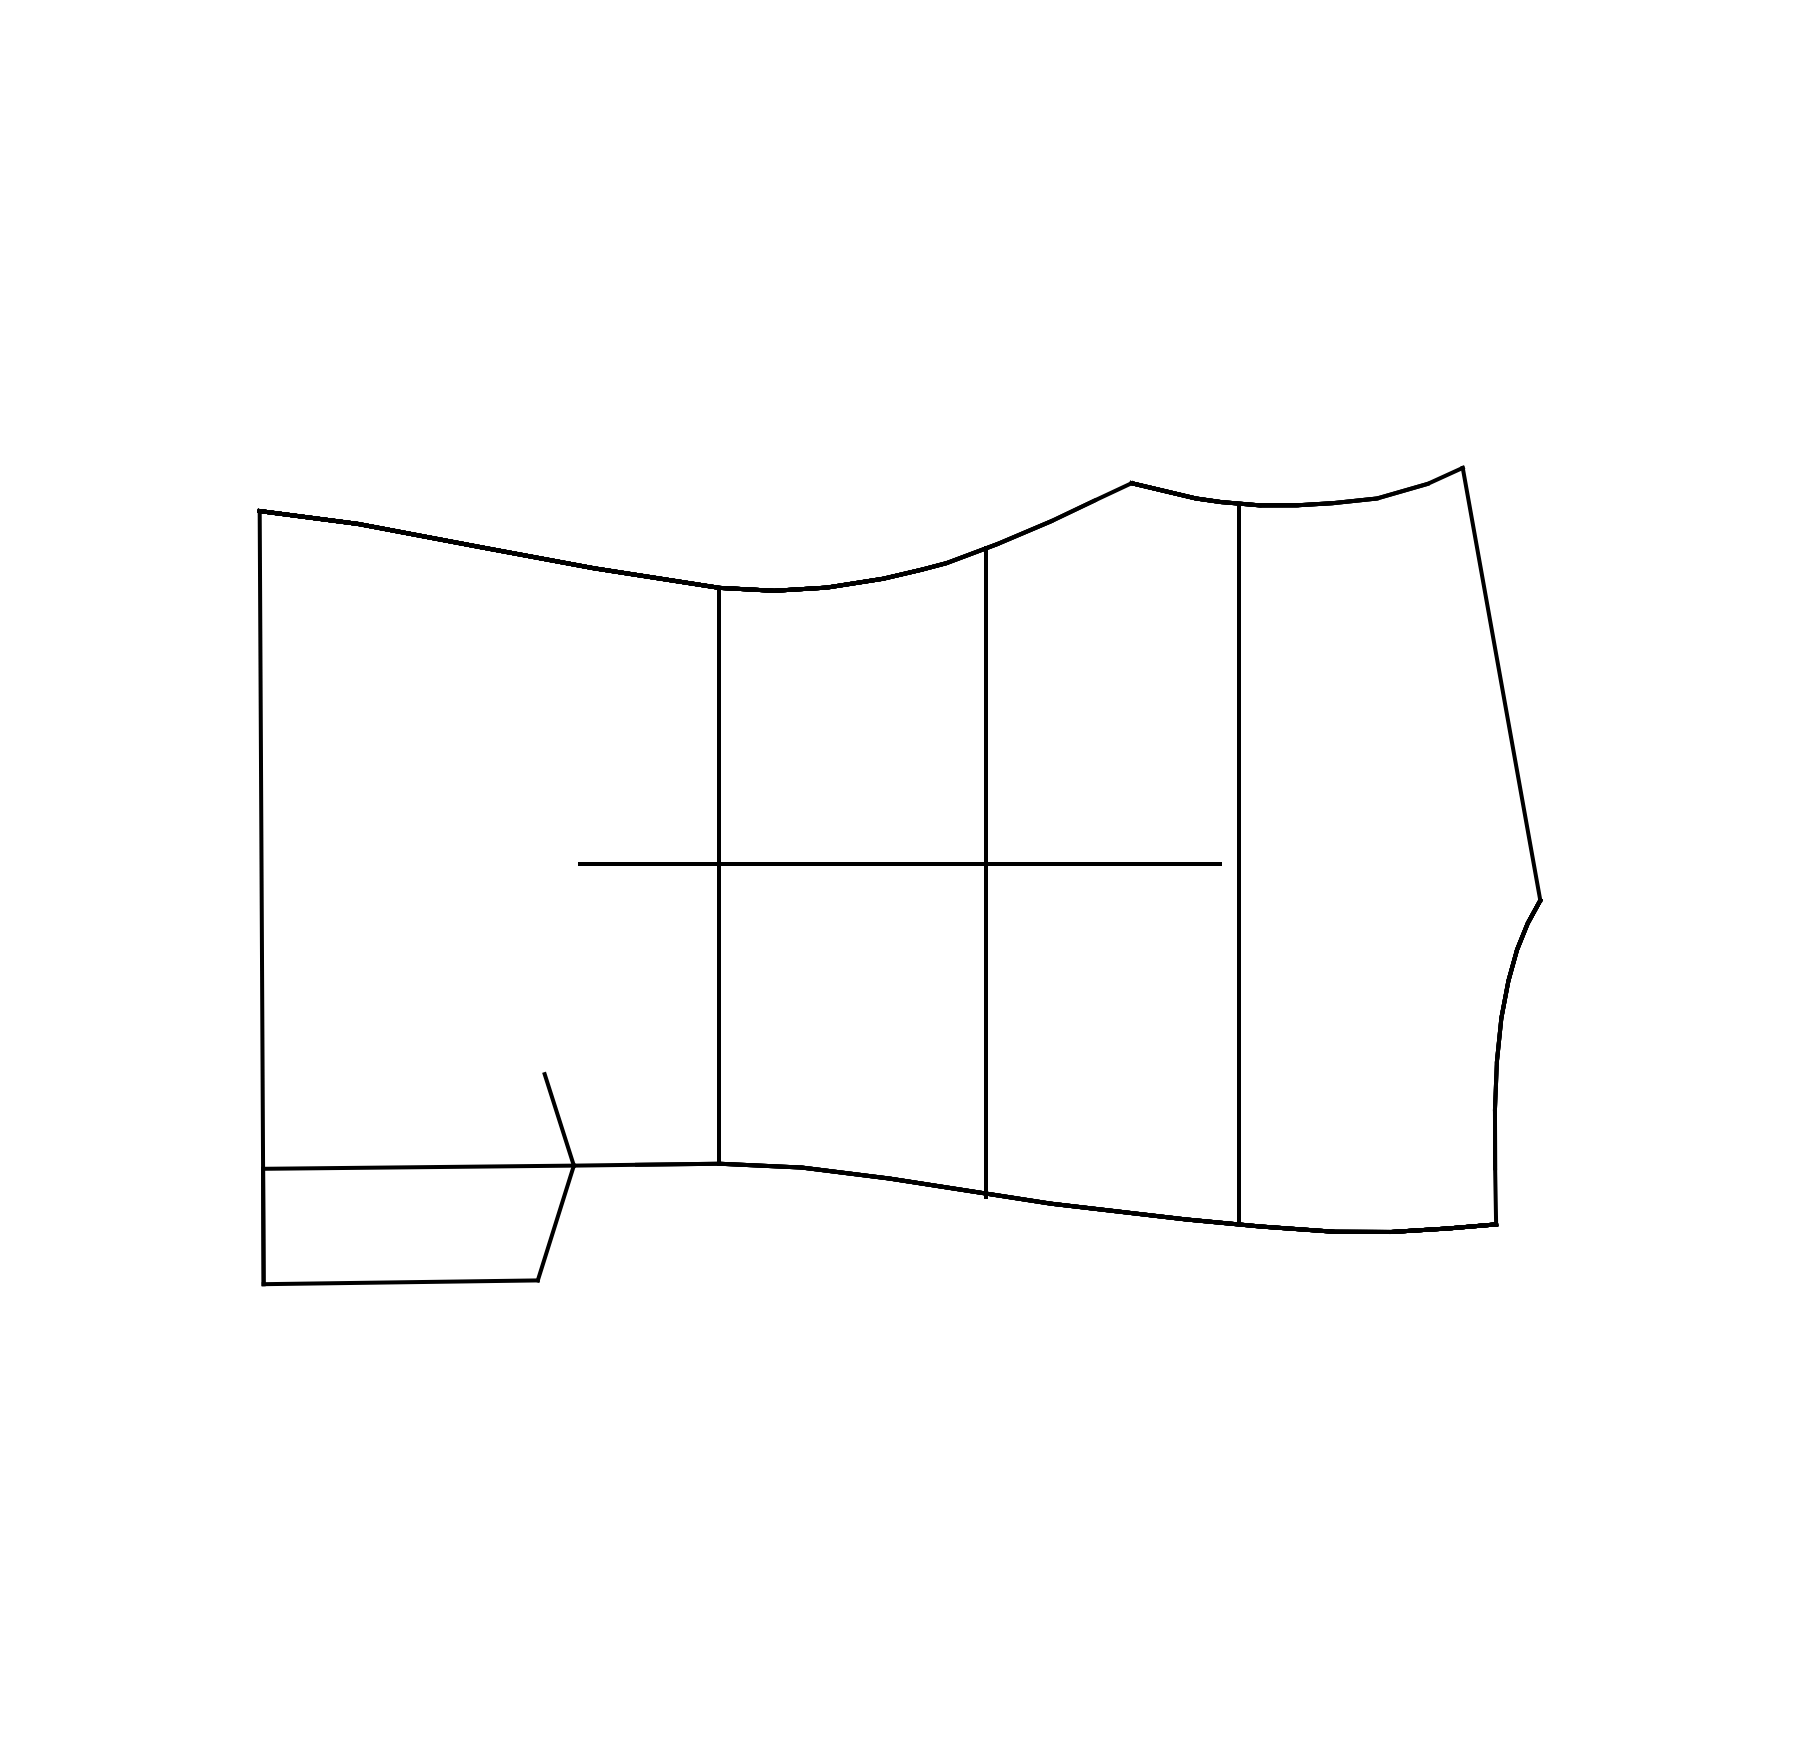

===== Picture 2 =====


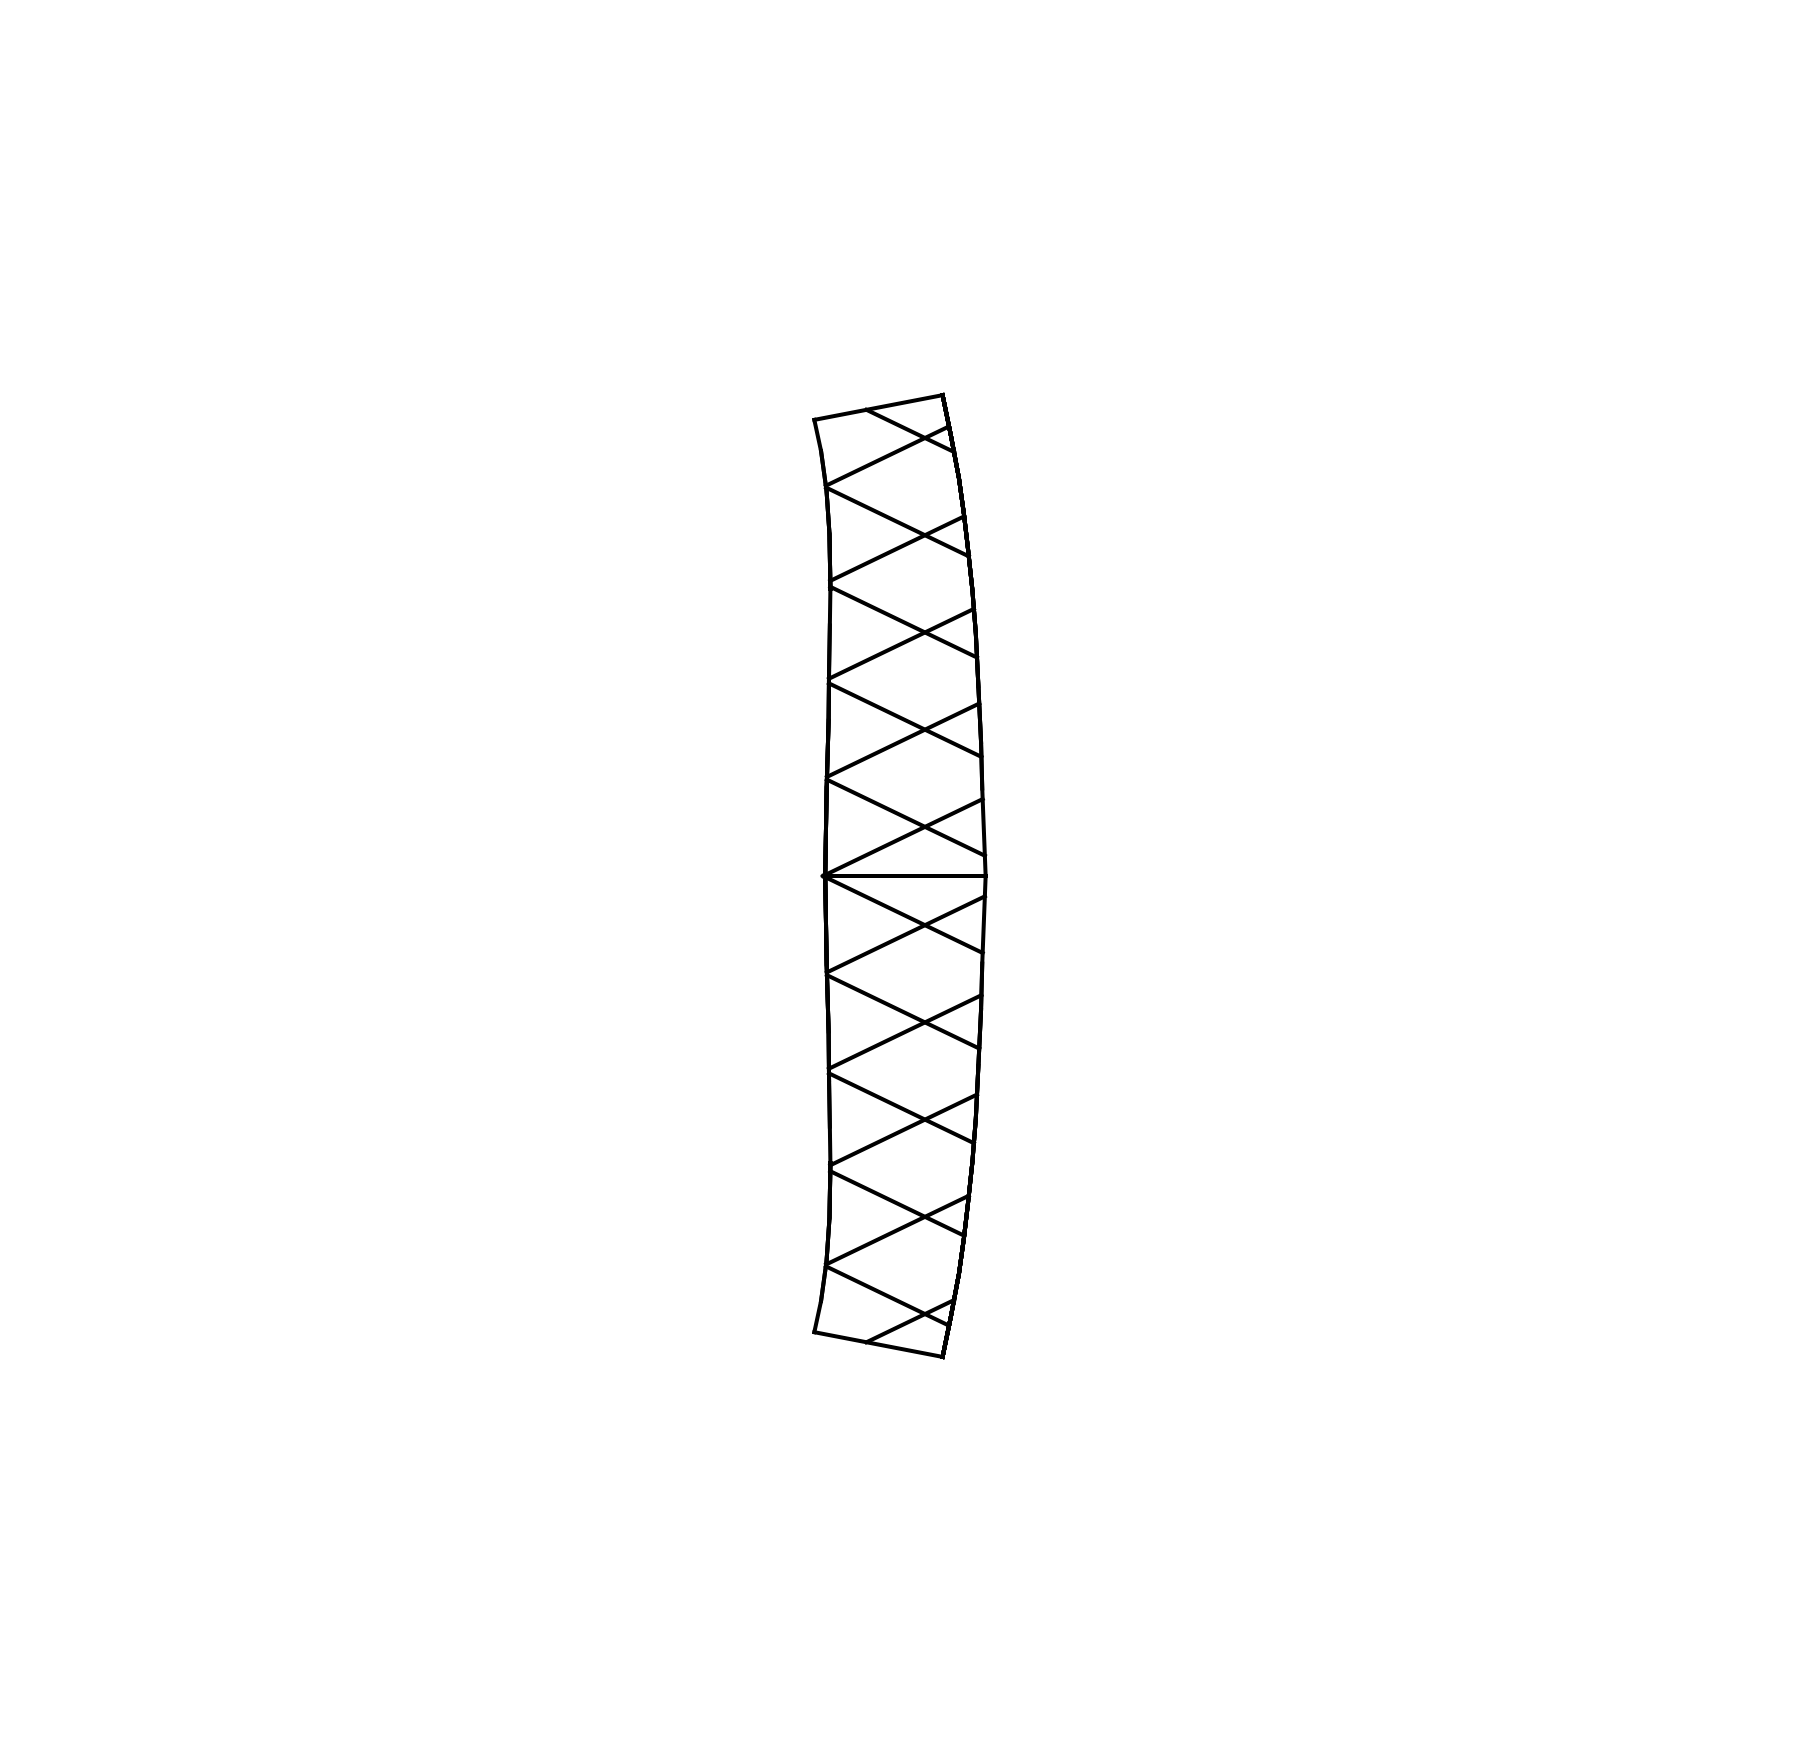

===== Picture 3 =====


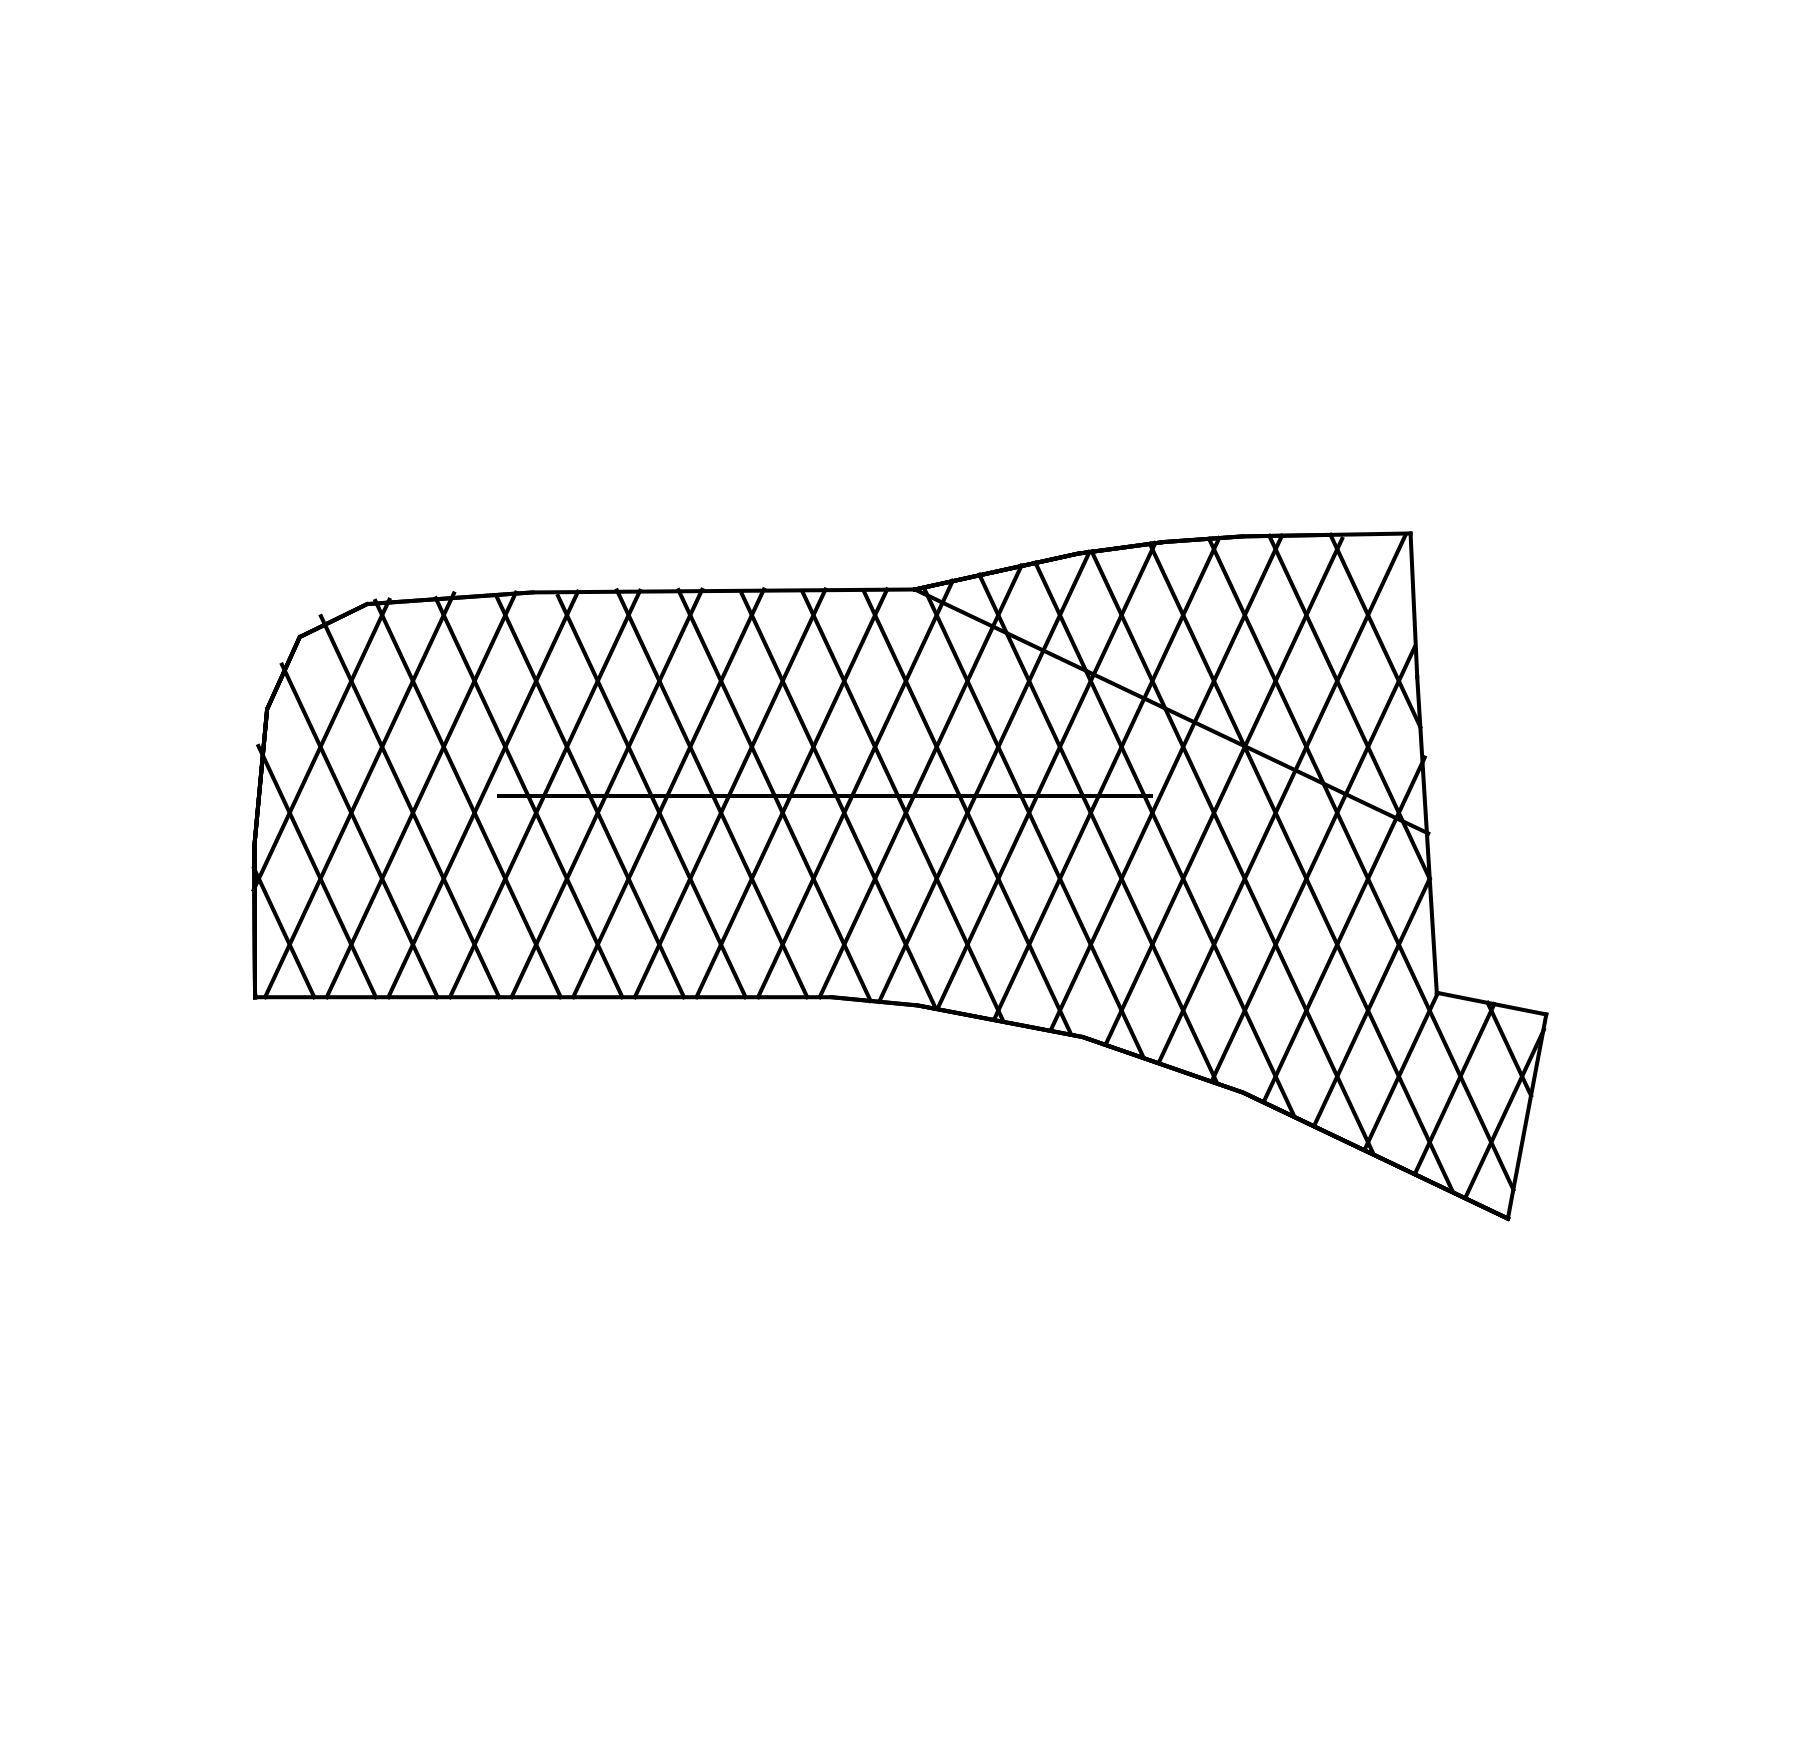

===== Picture 4 =====


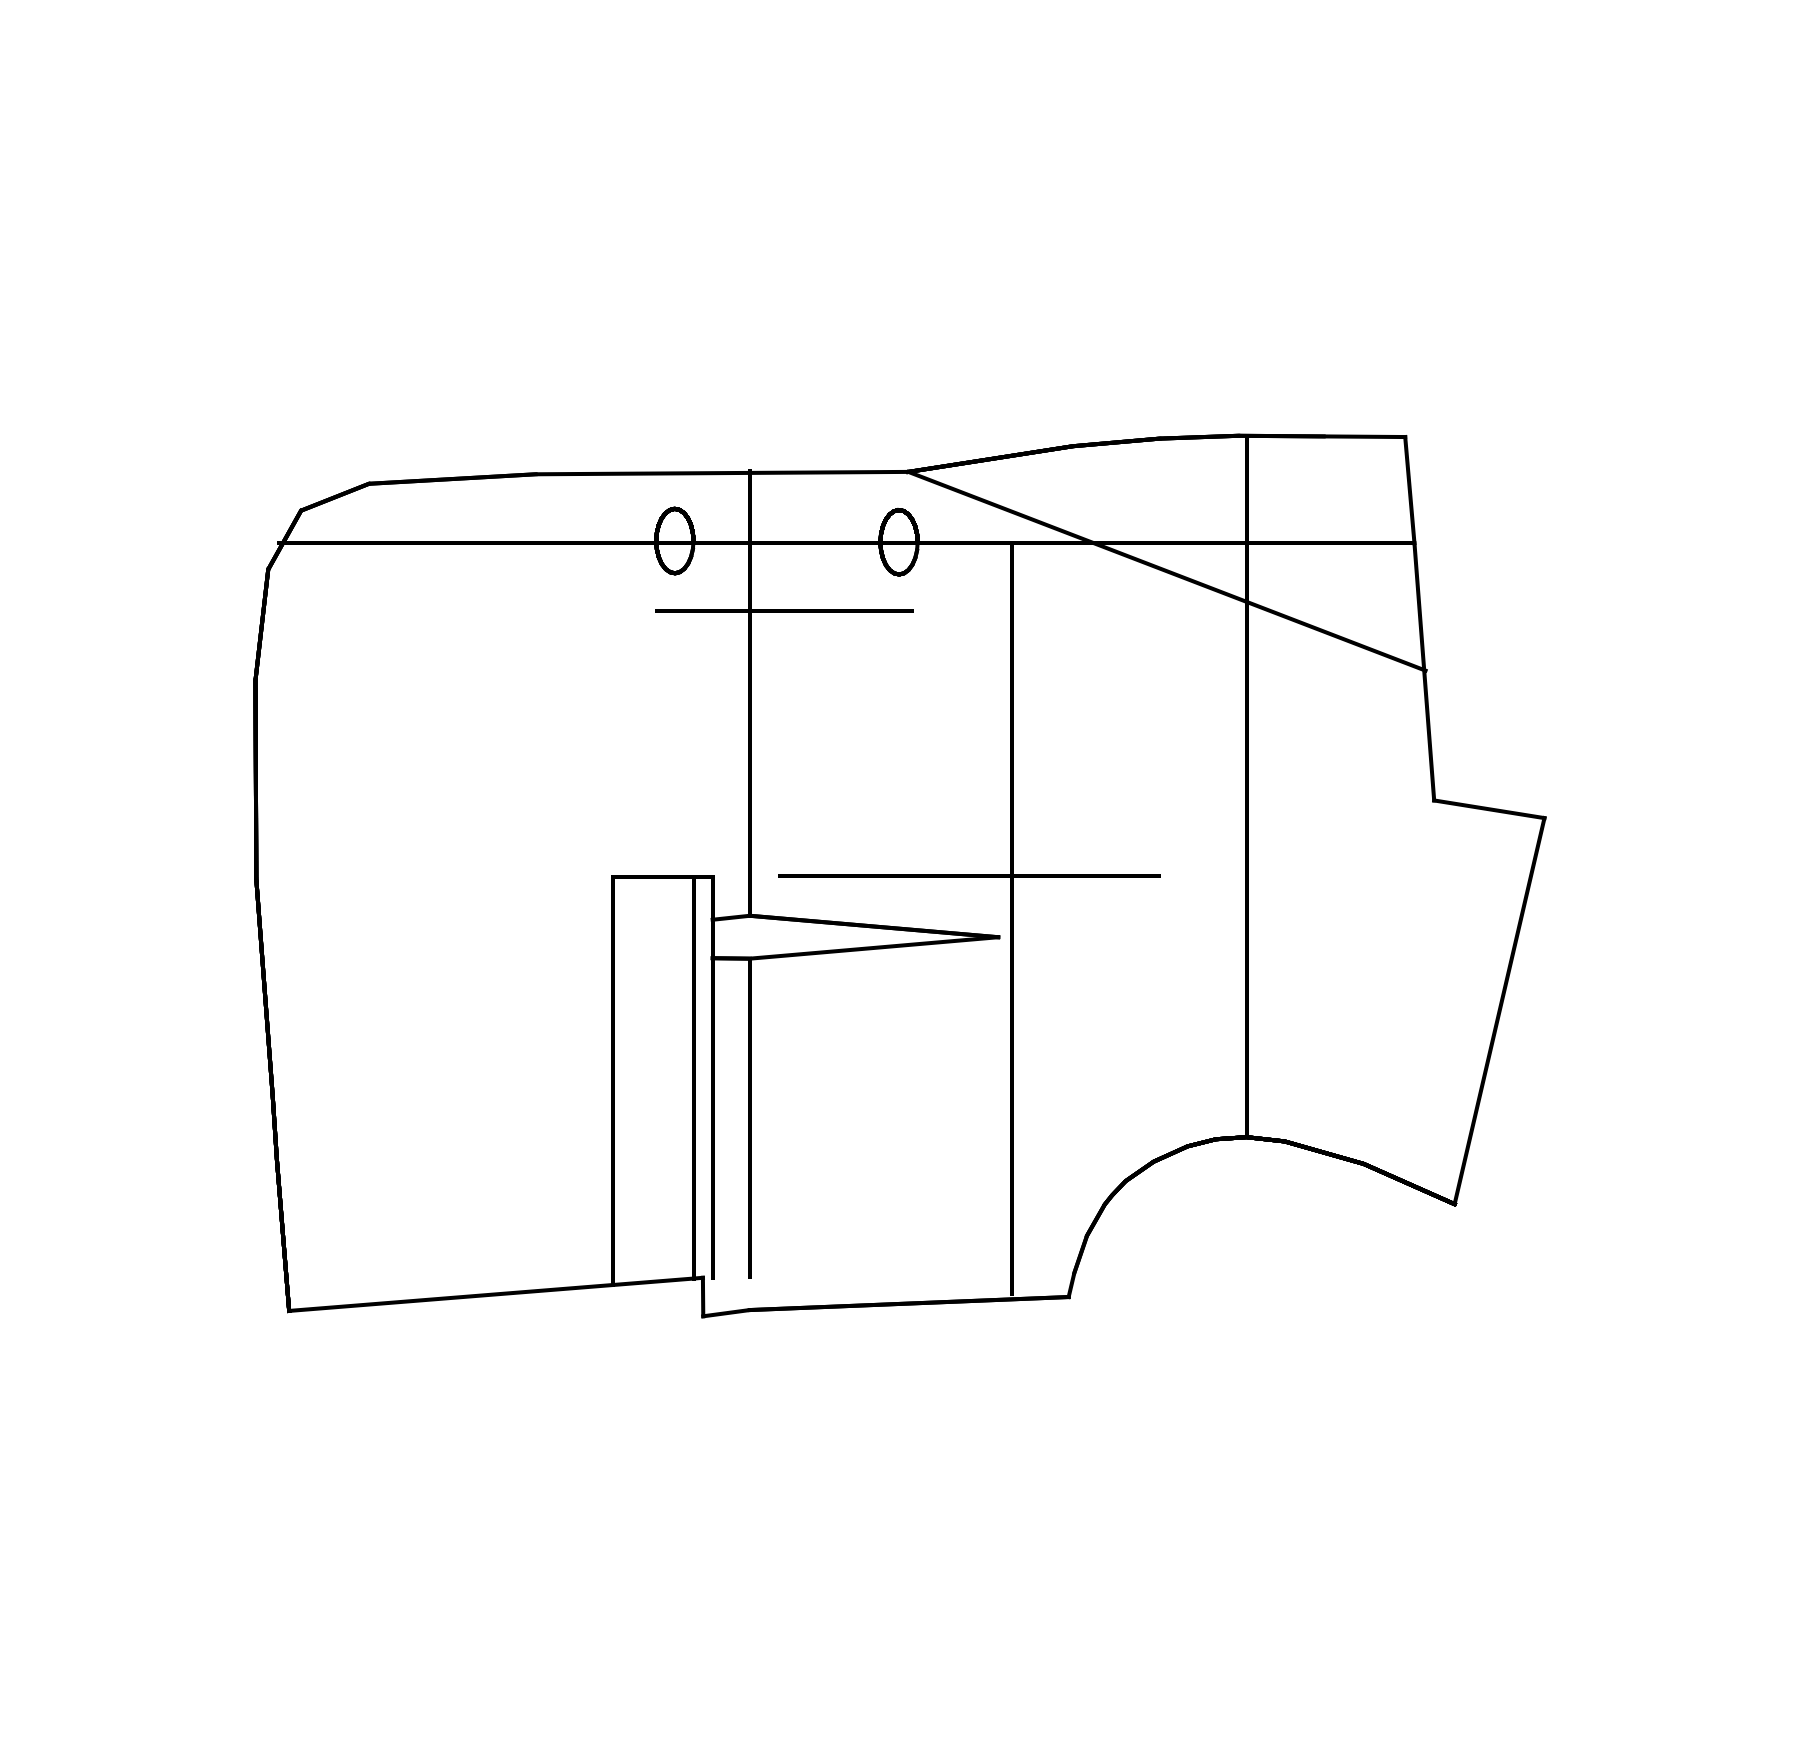

===== Picture 5 =====


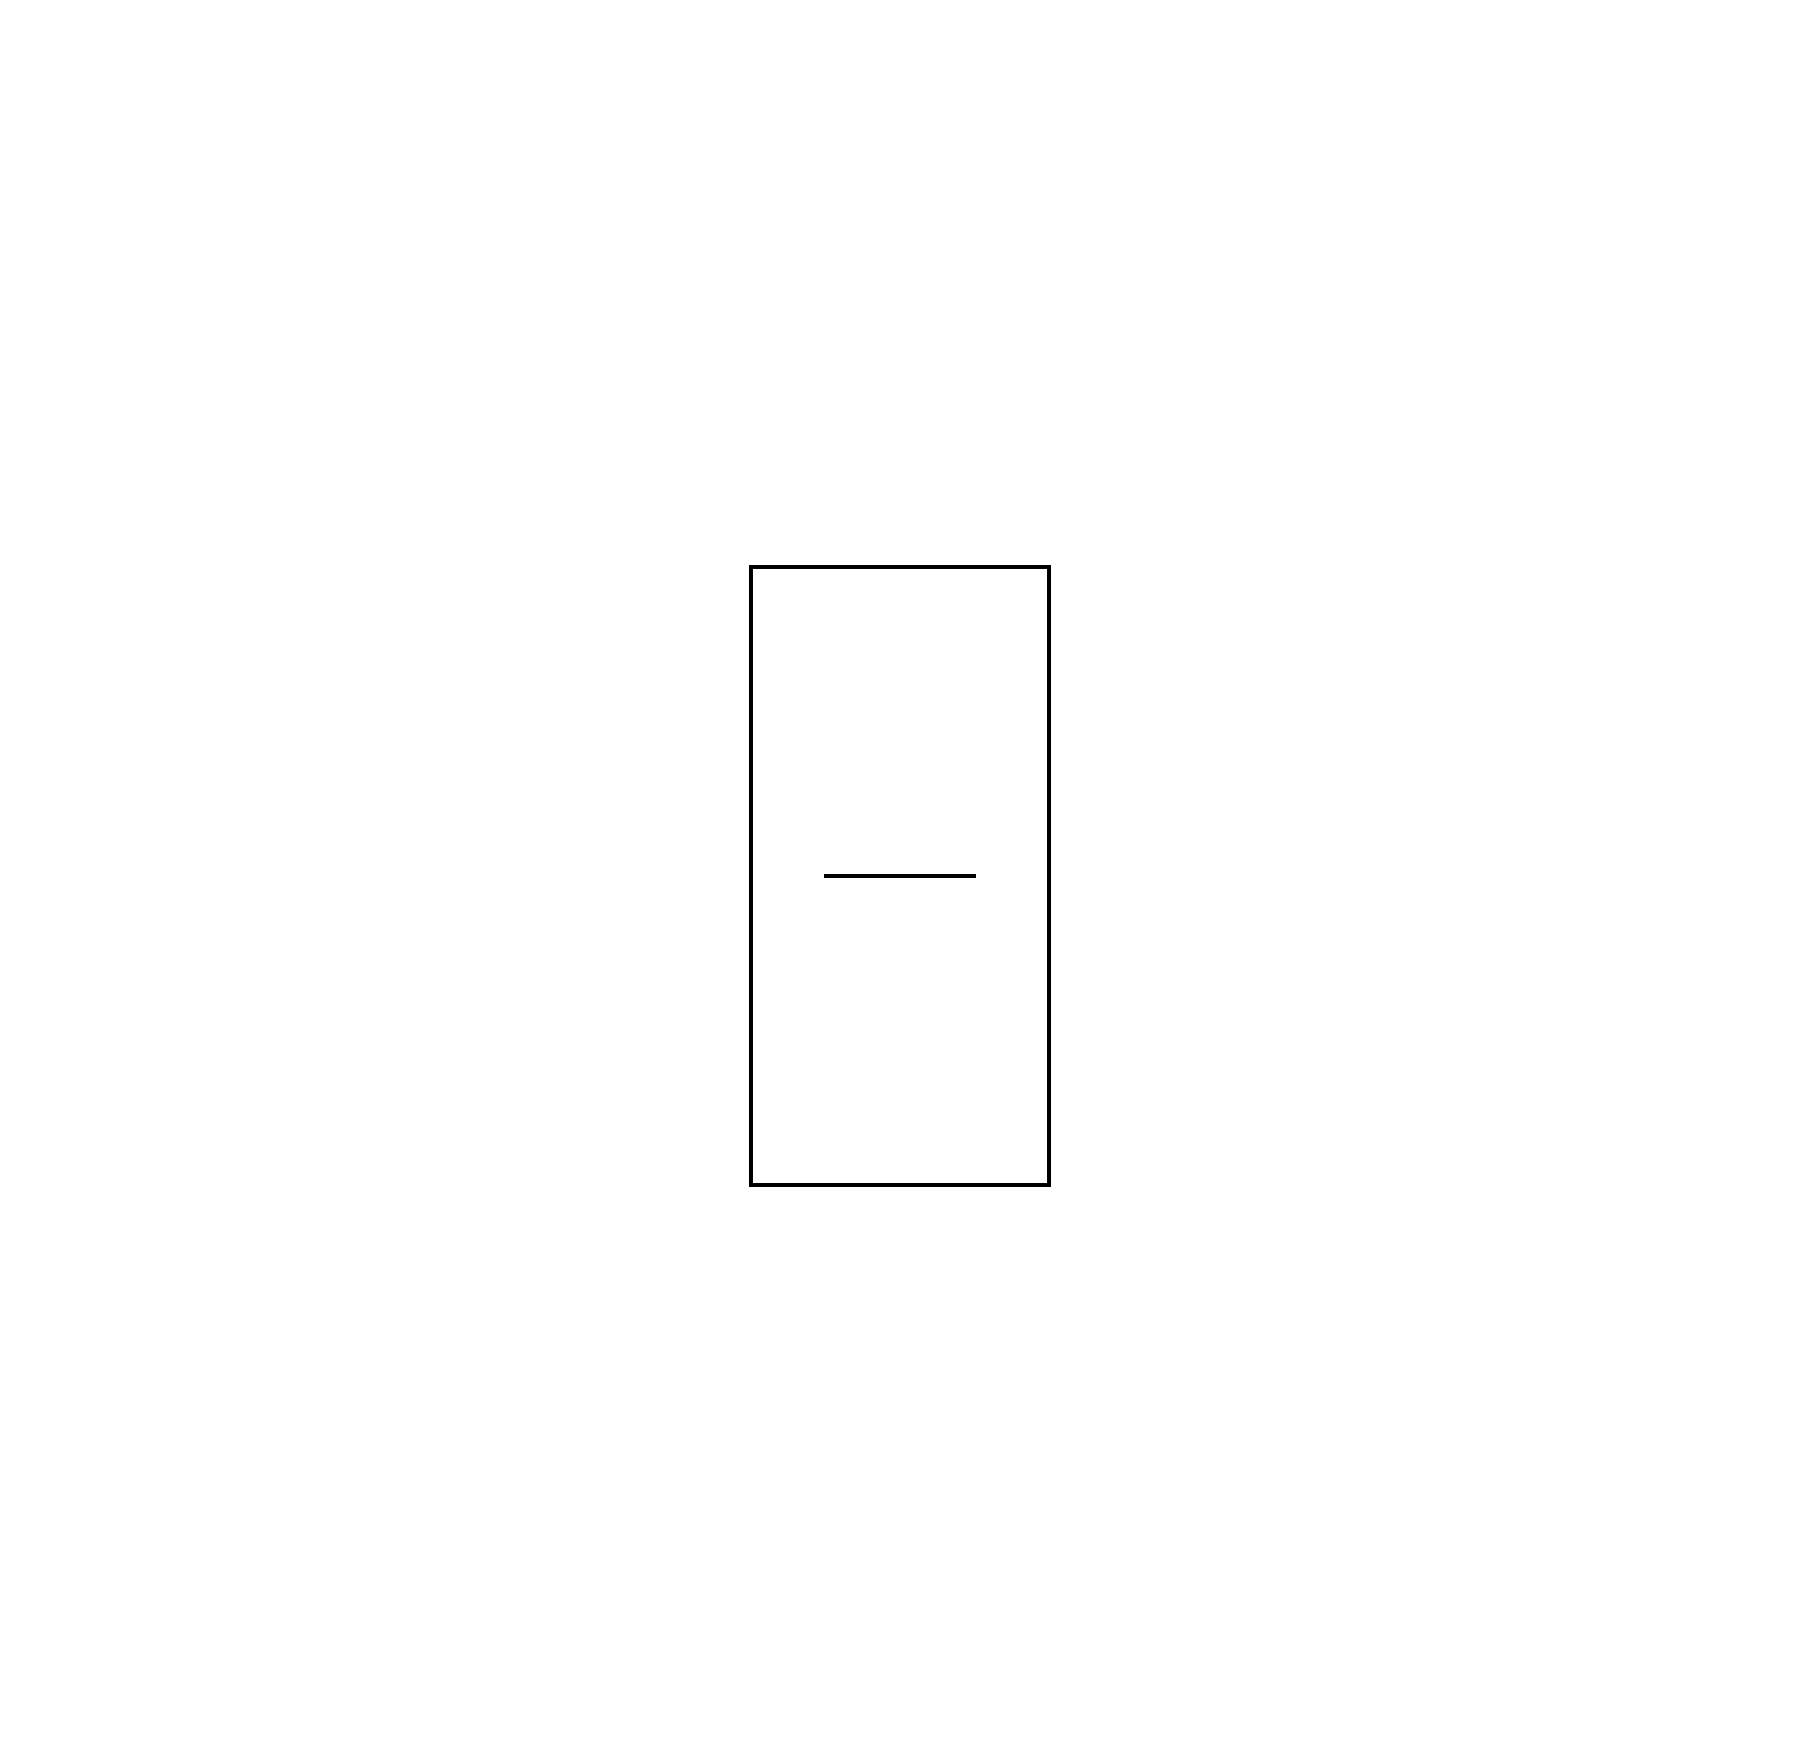

===== Picture 6 =====


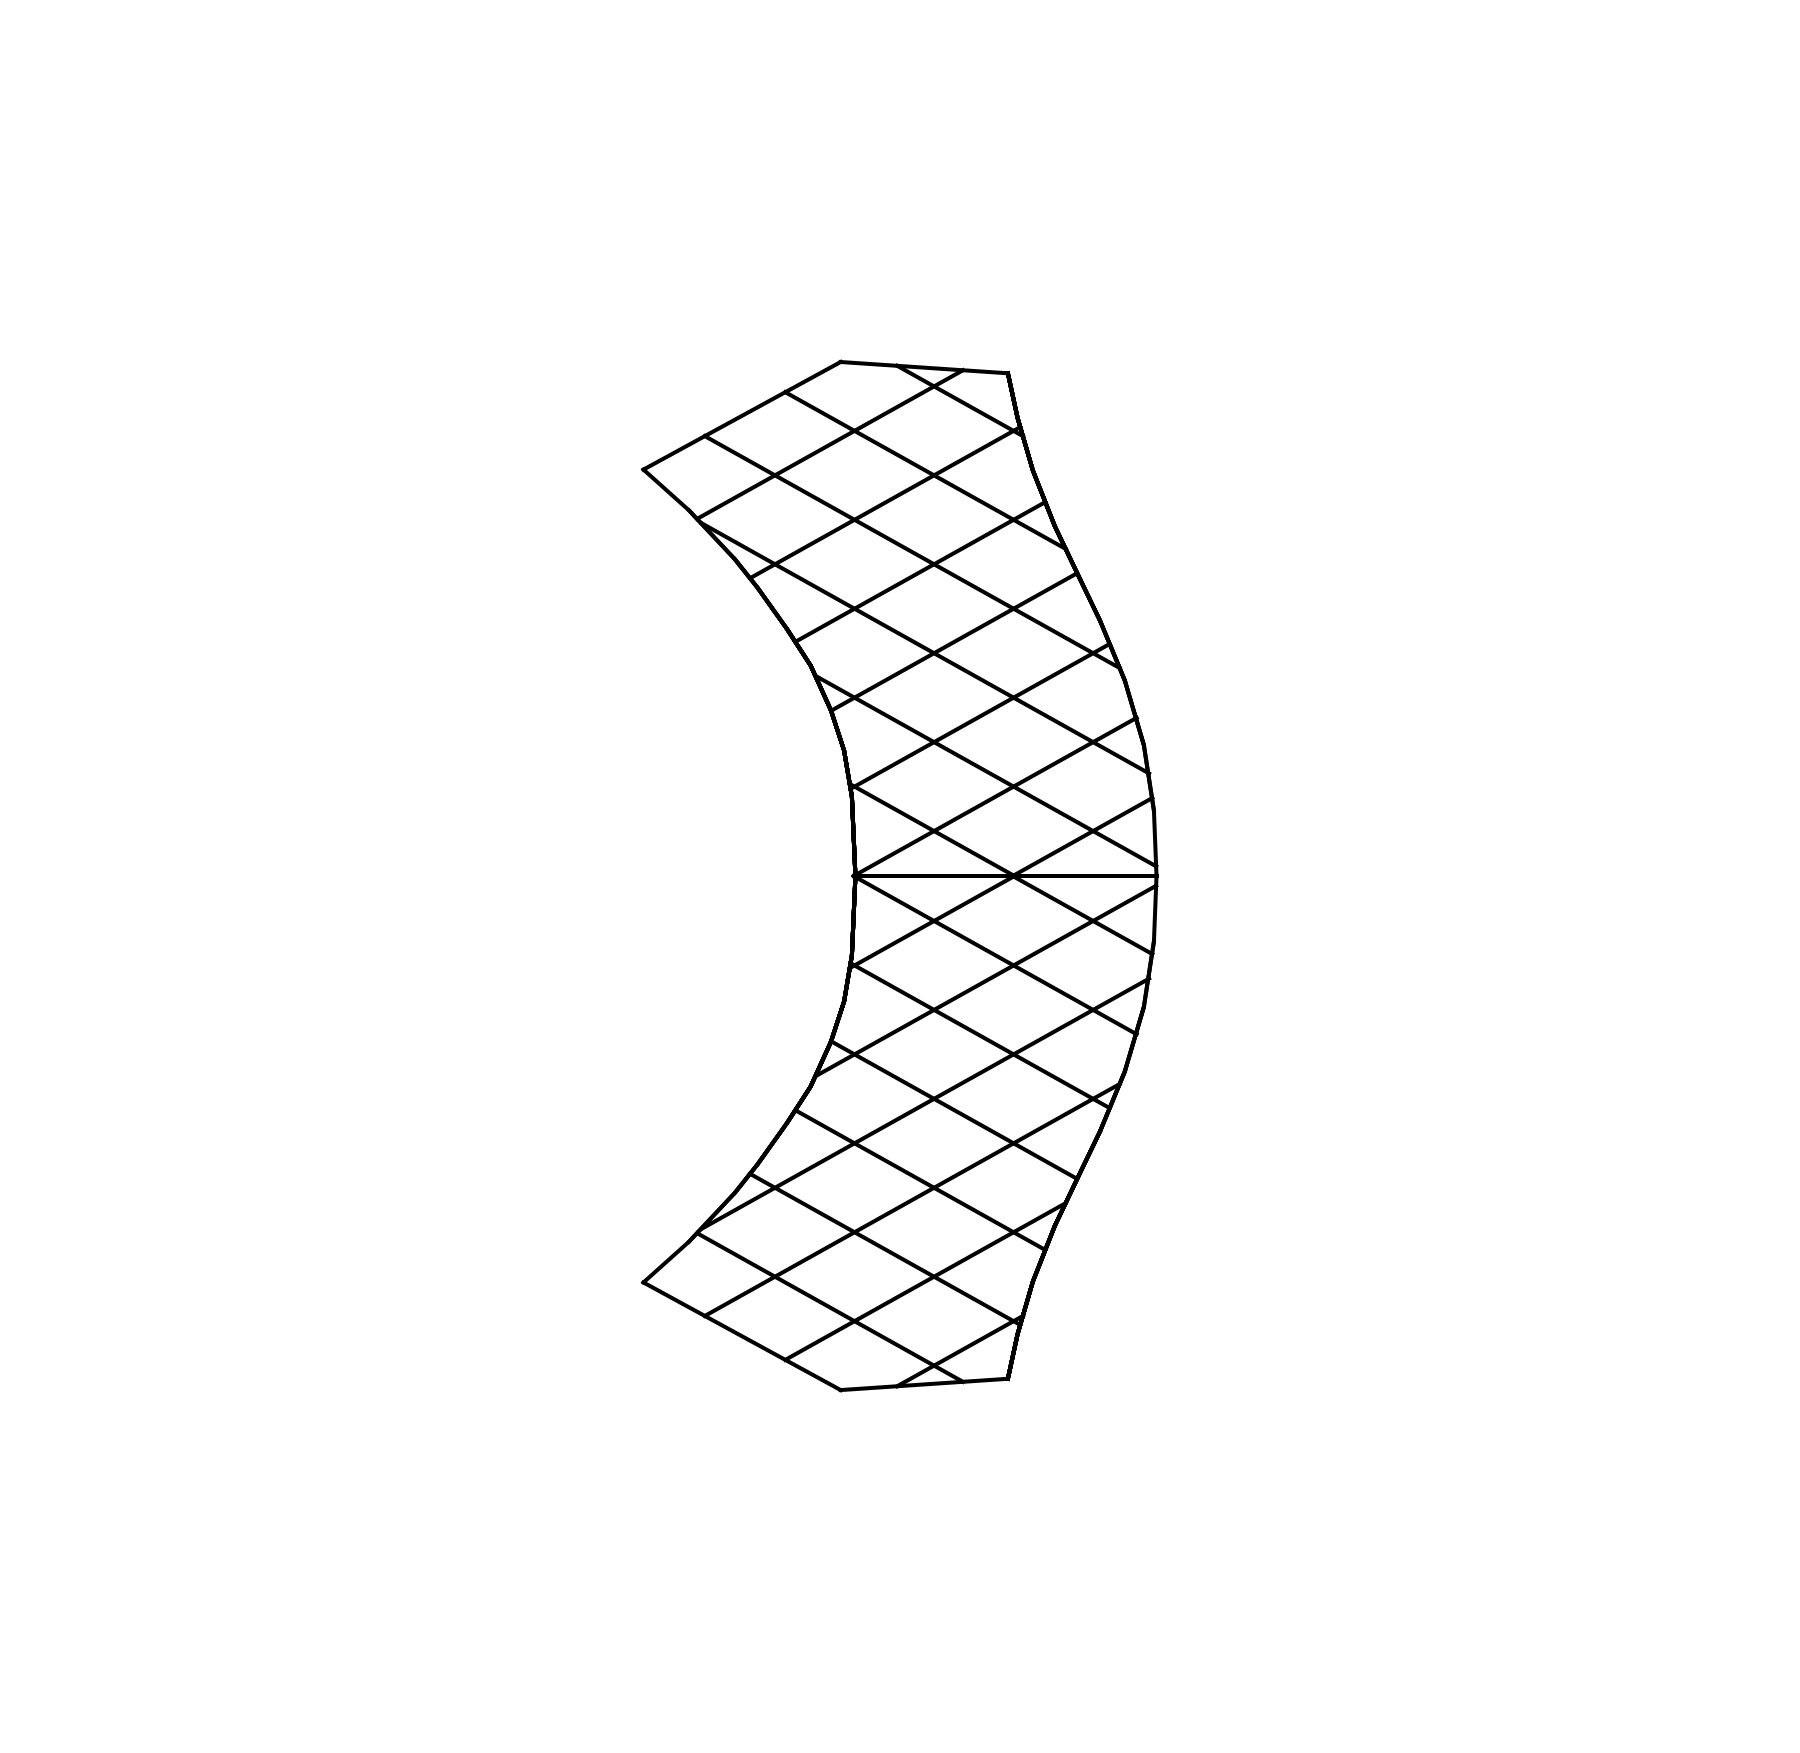

===== Picture 7 =====


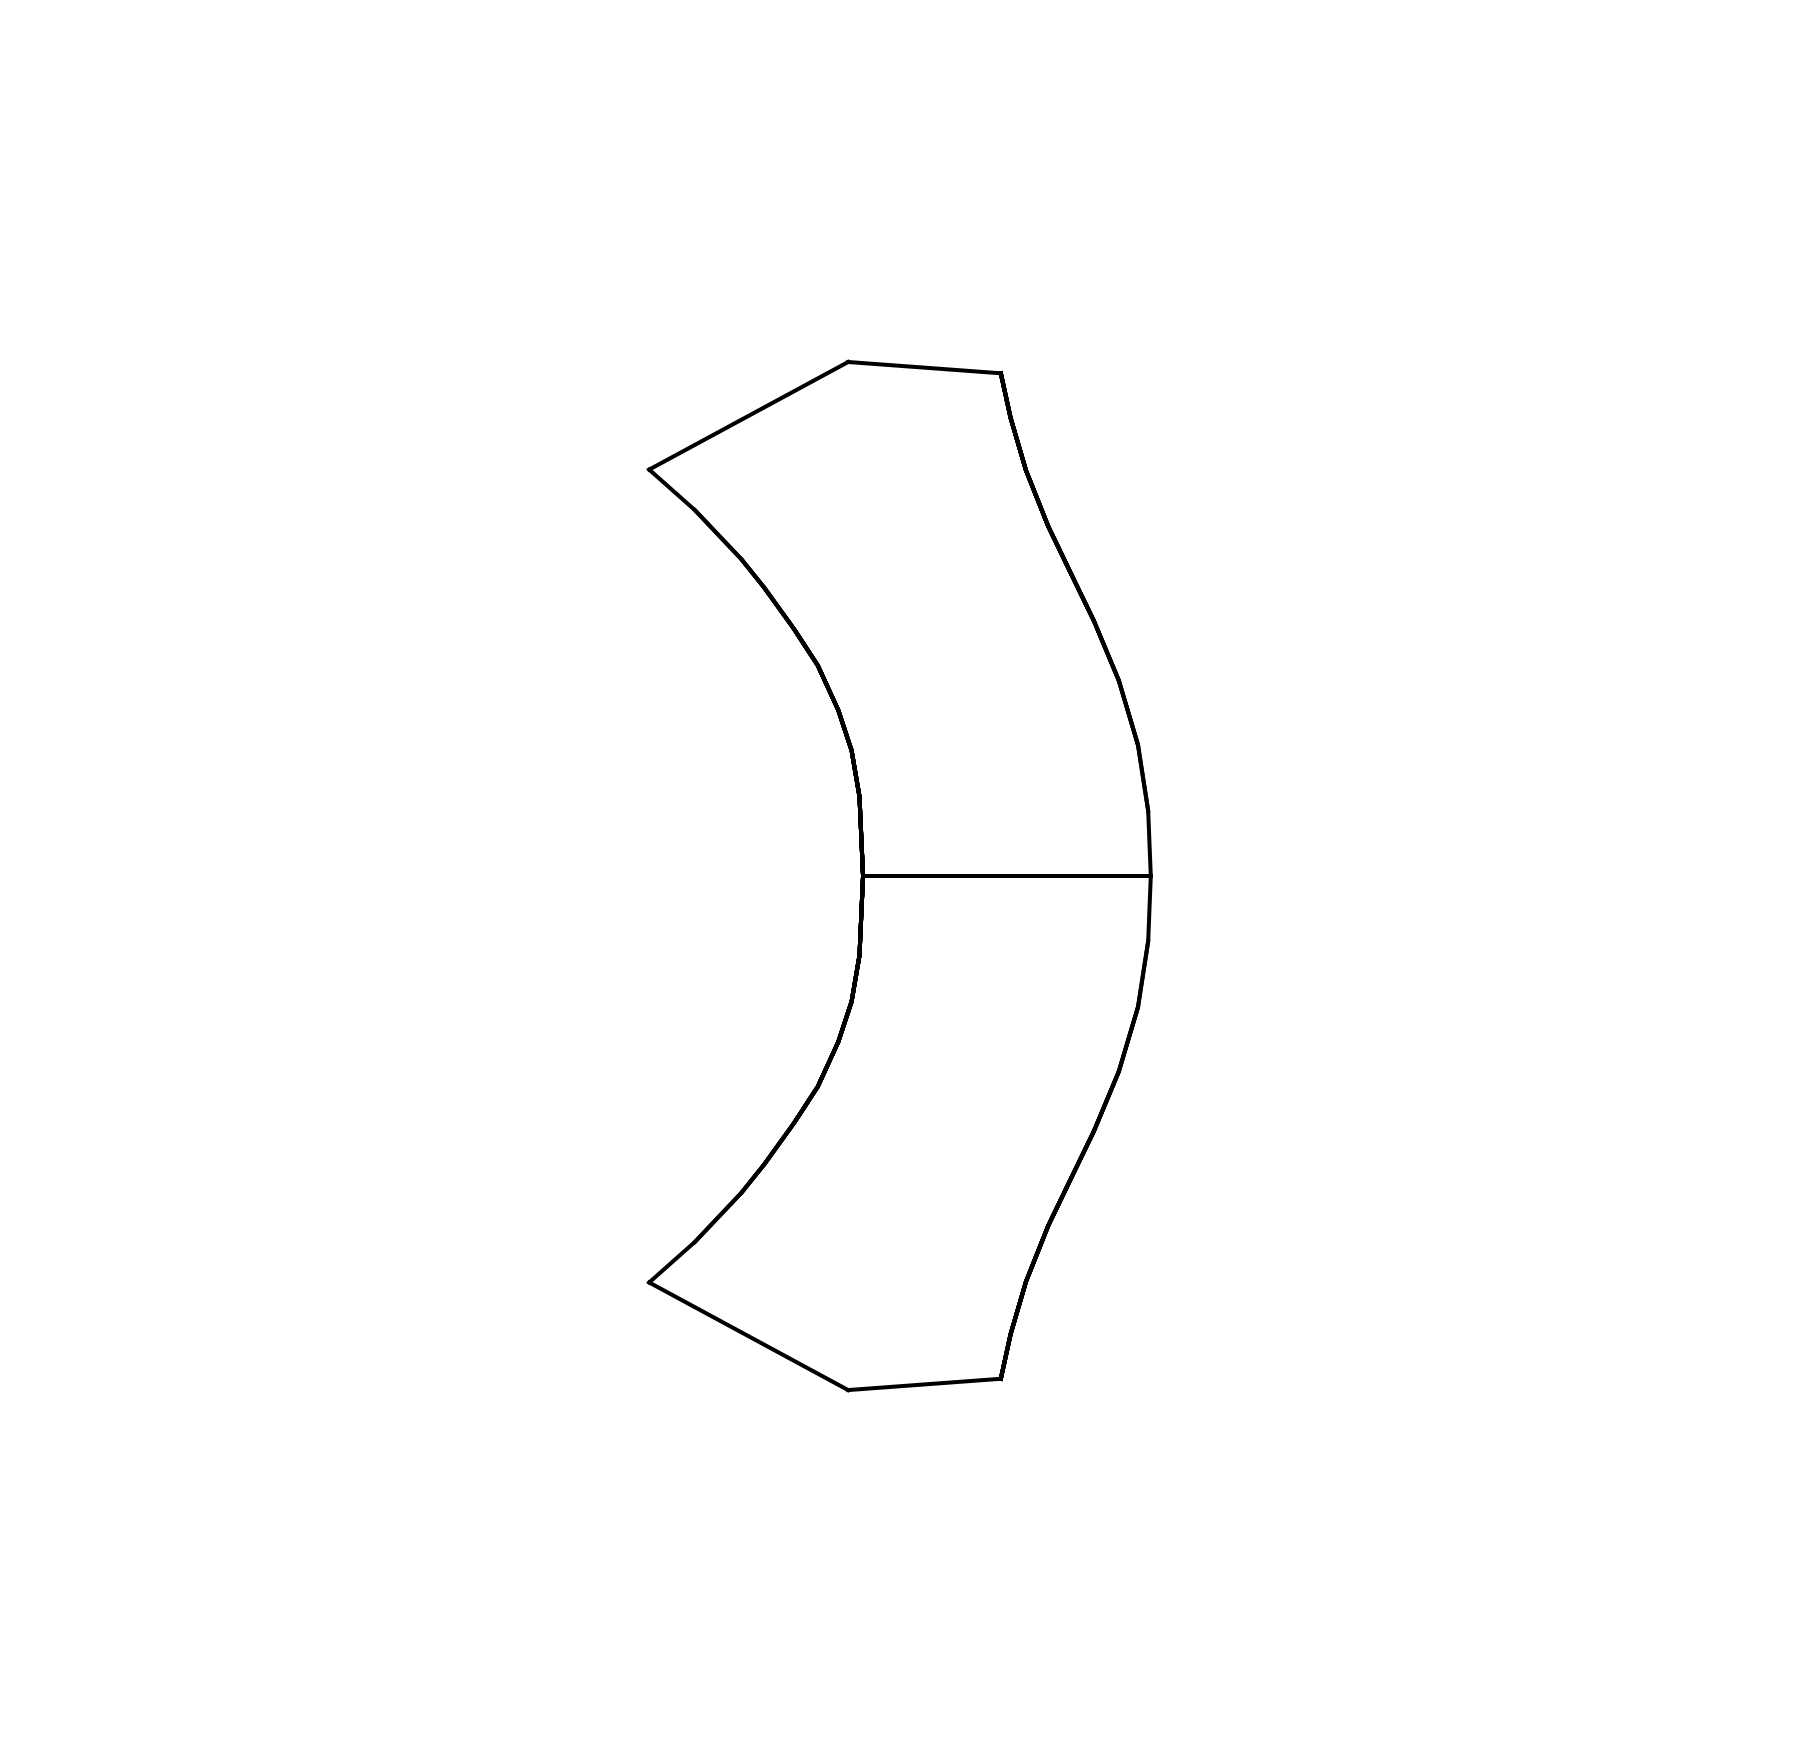

===== Picture 8 =====


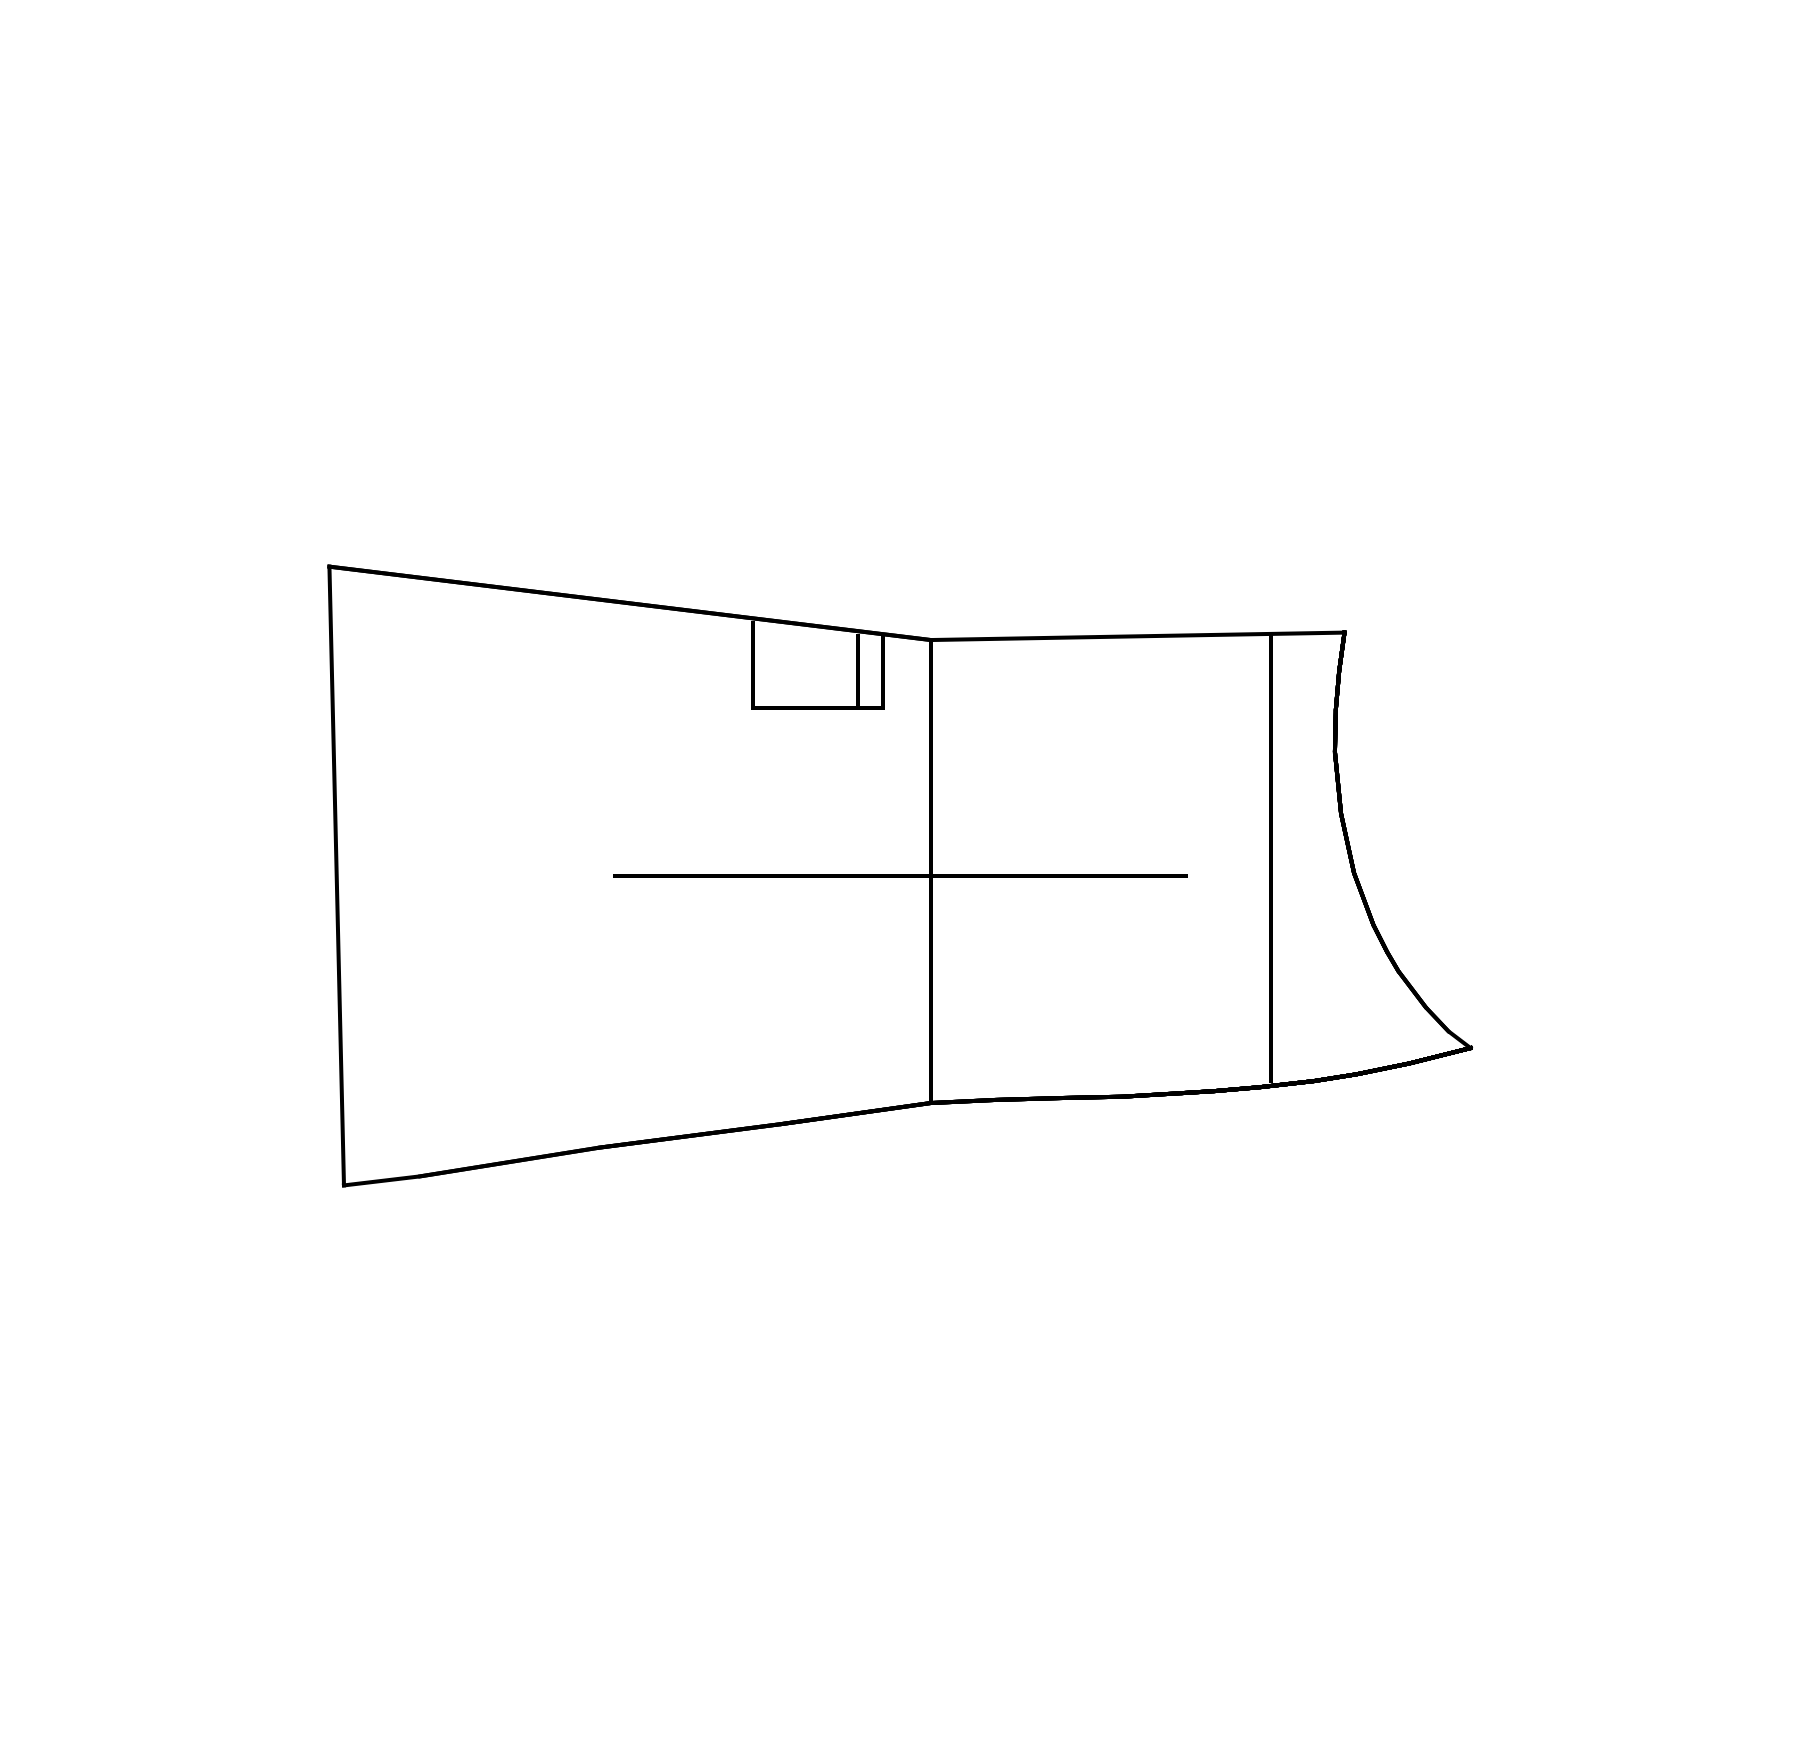

===== Picture 9 =====


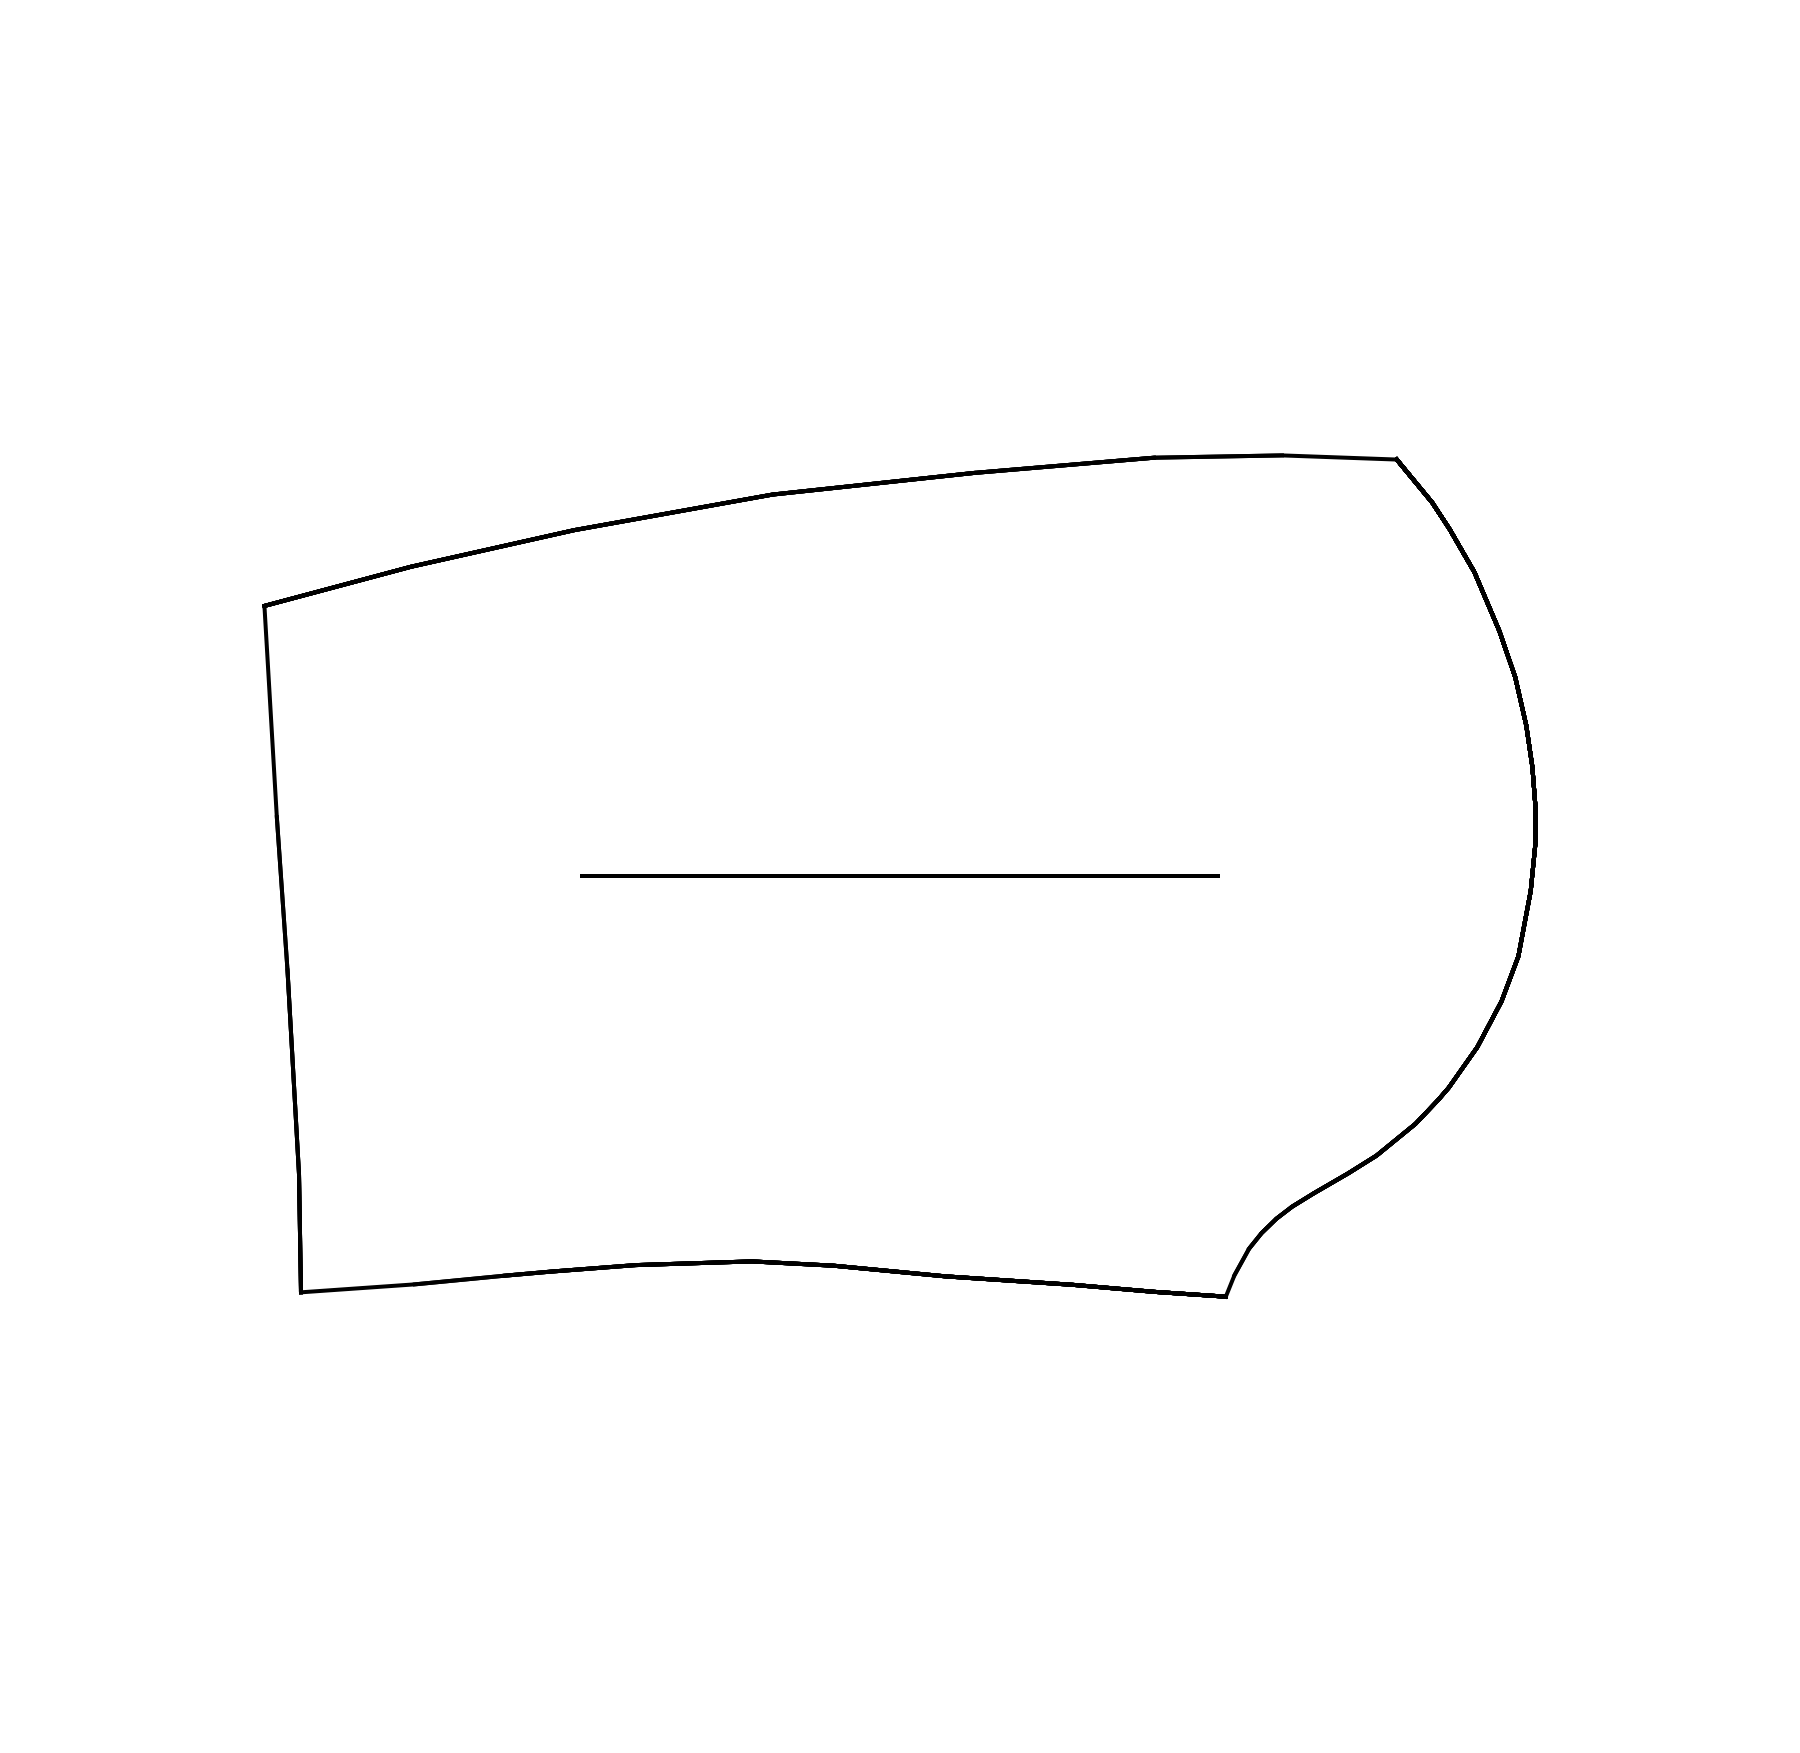

===== Picture 10 =====


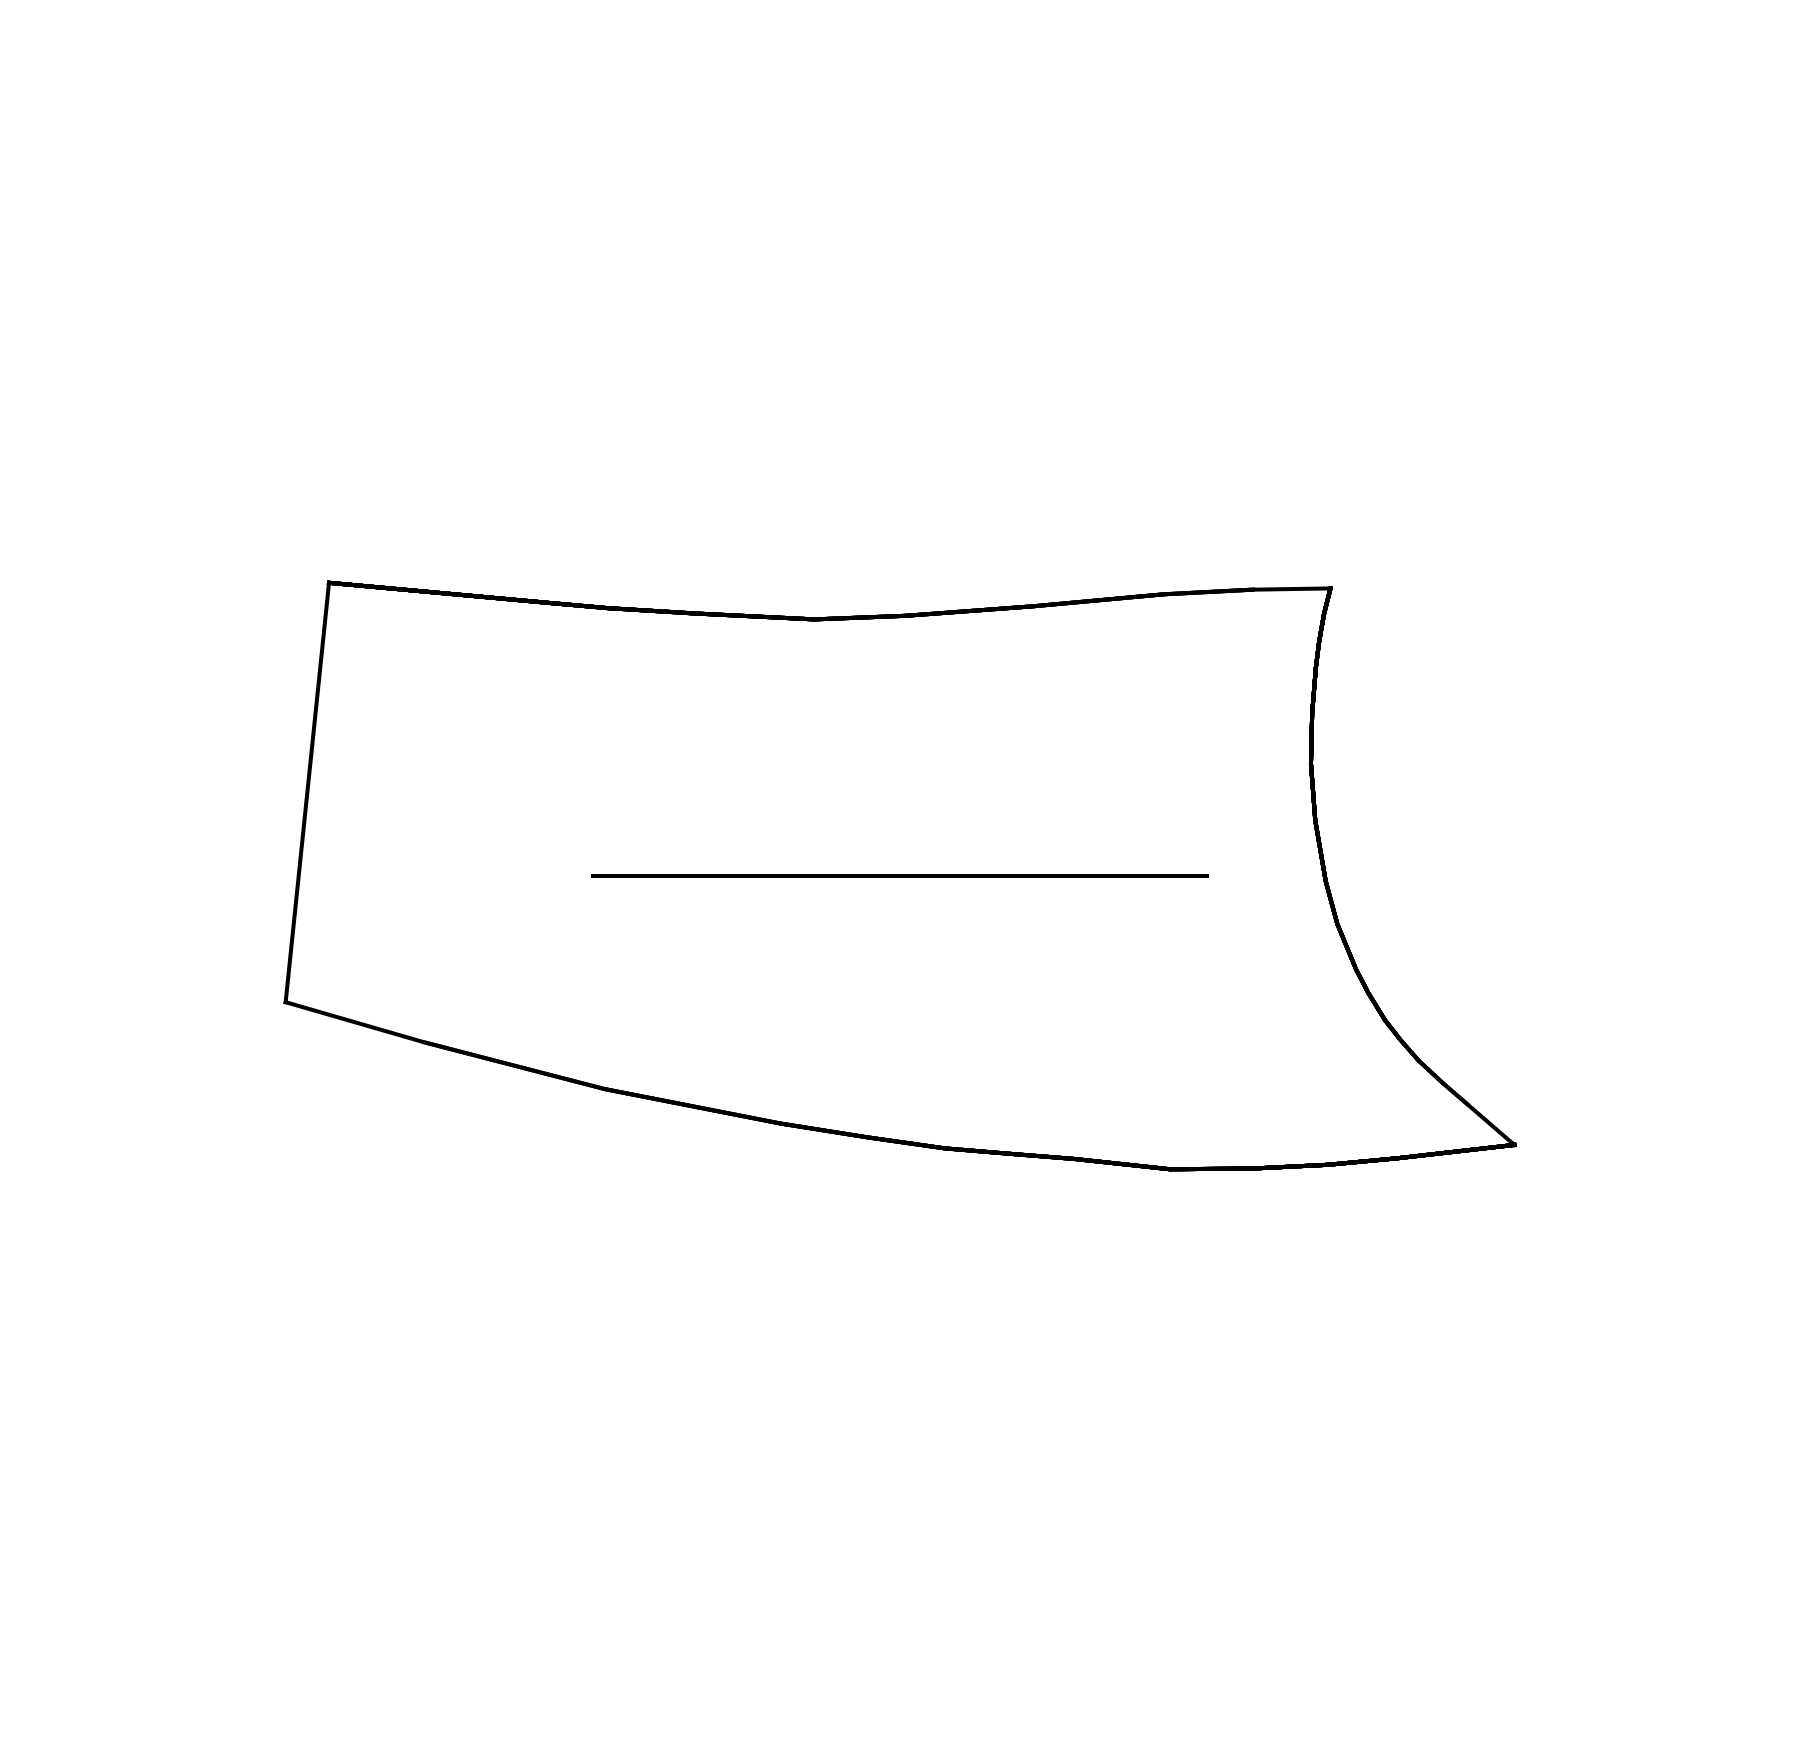

===== Picture 11 =====


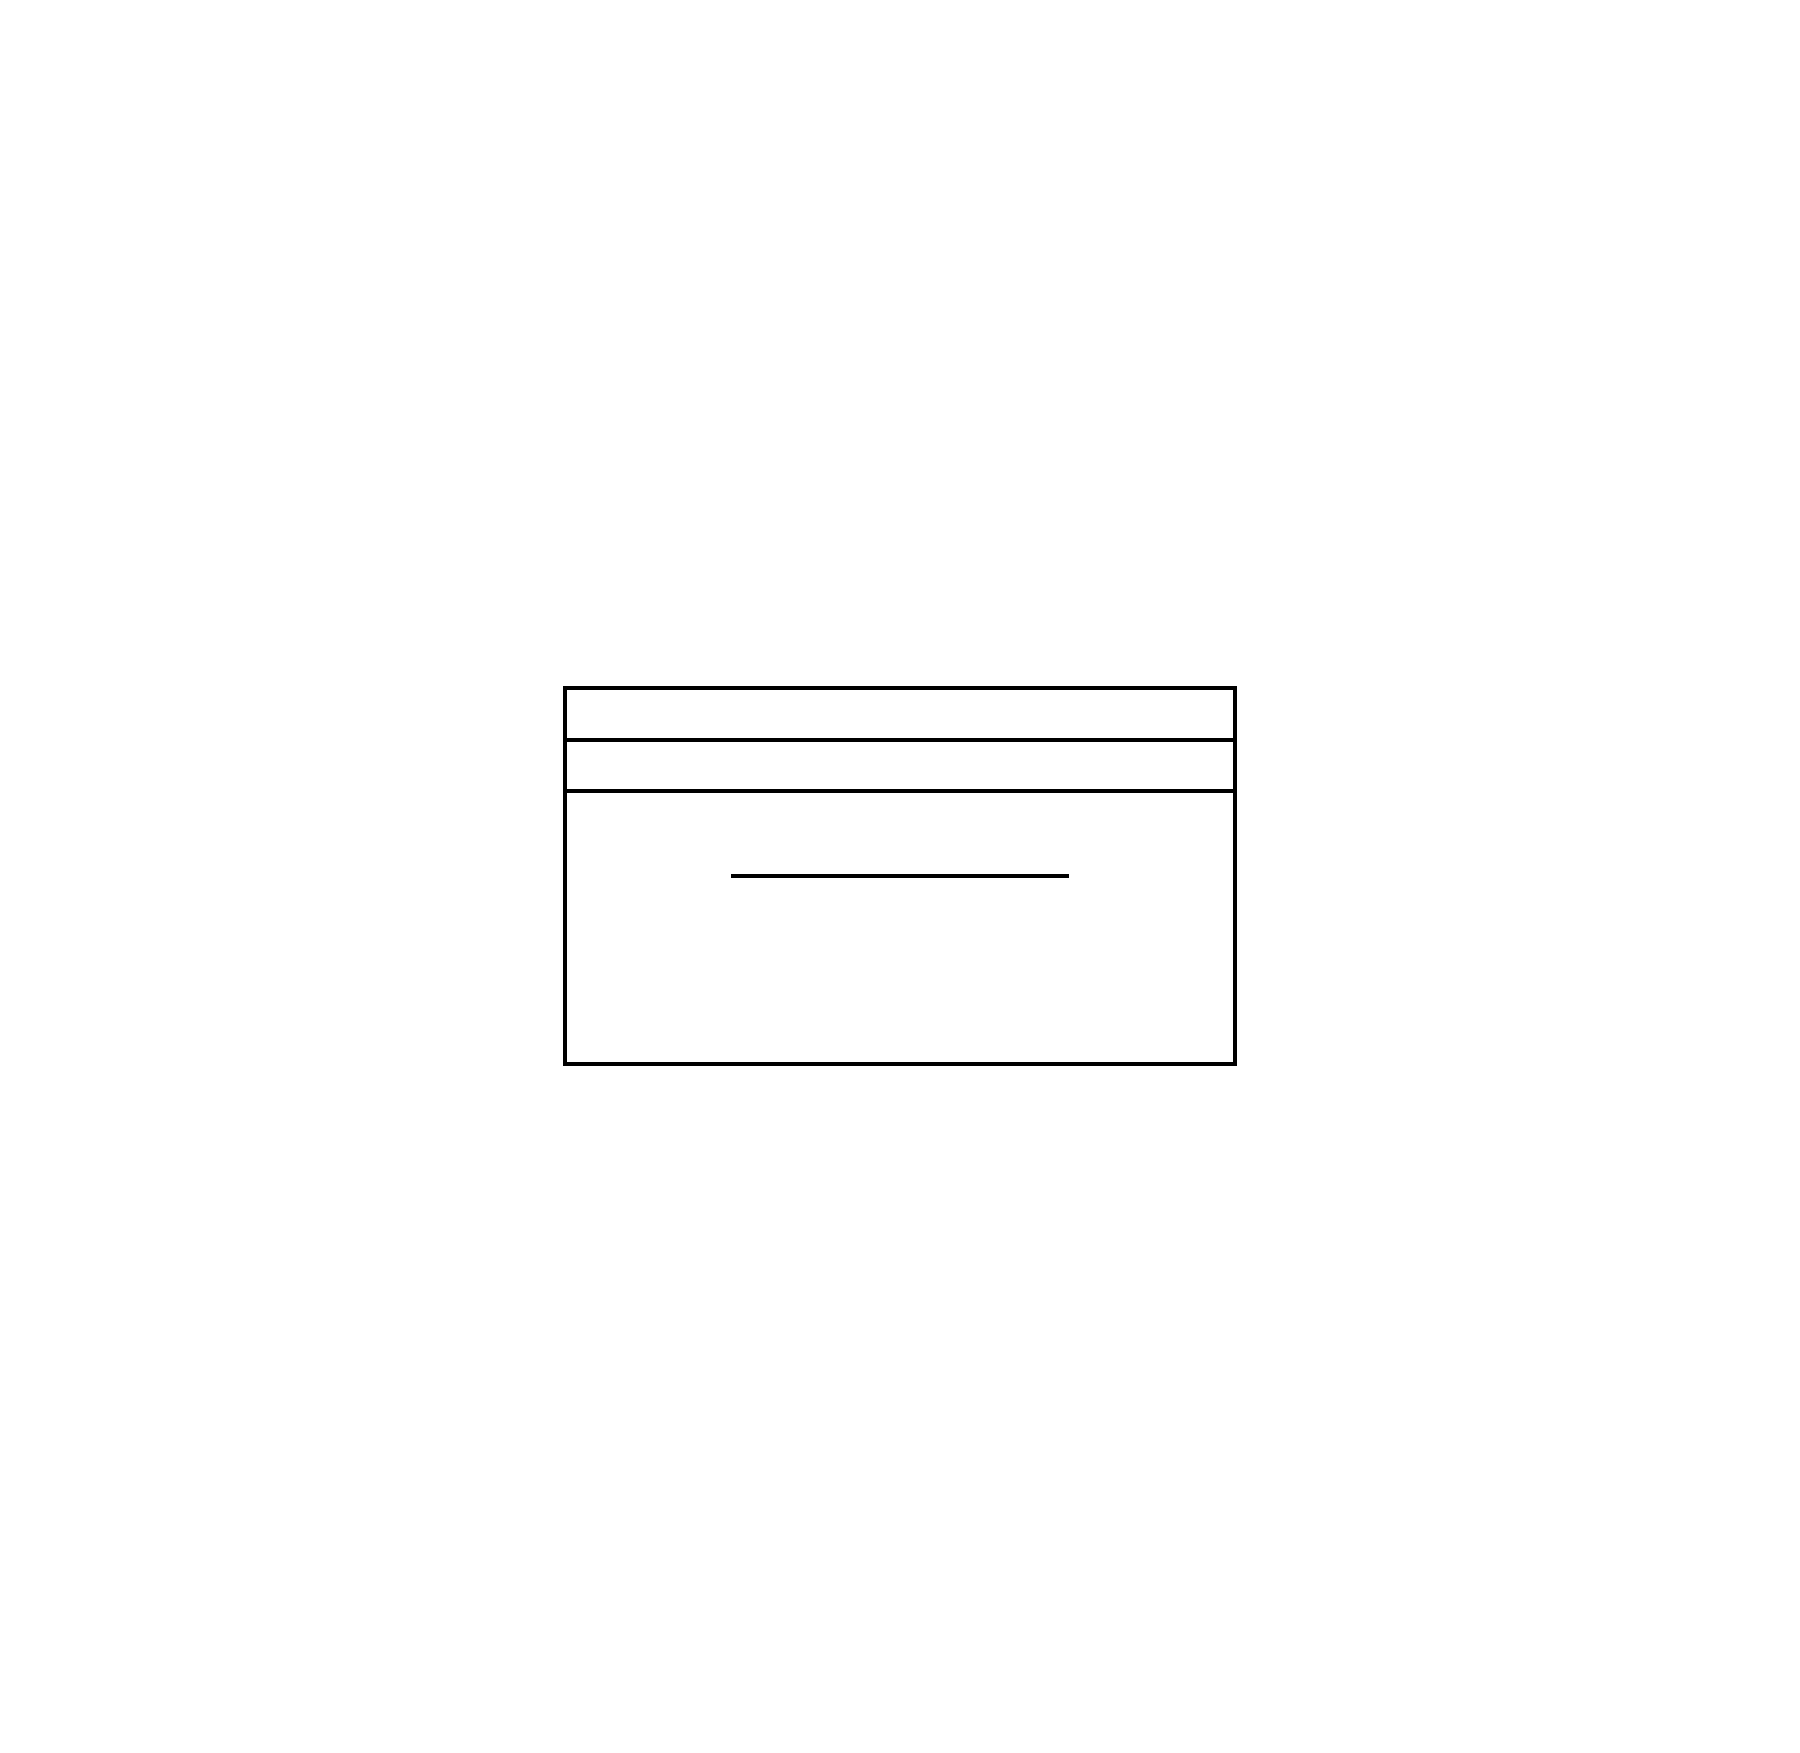

===== Picture 12 =====


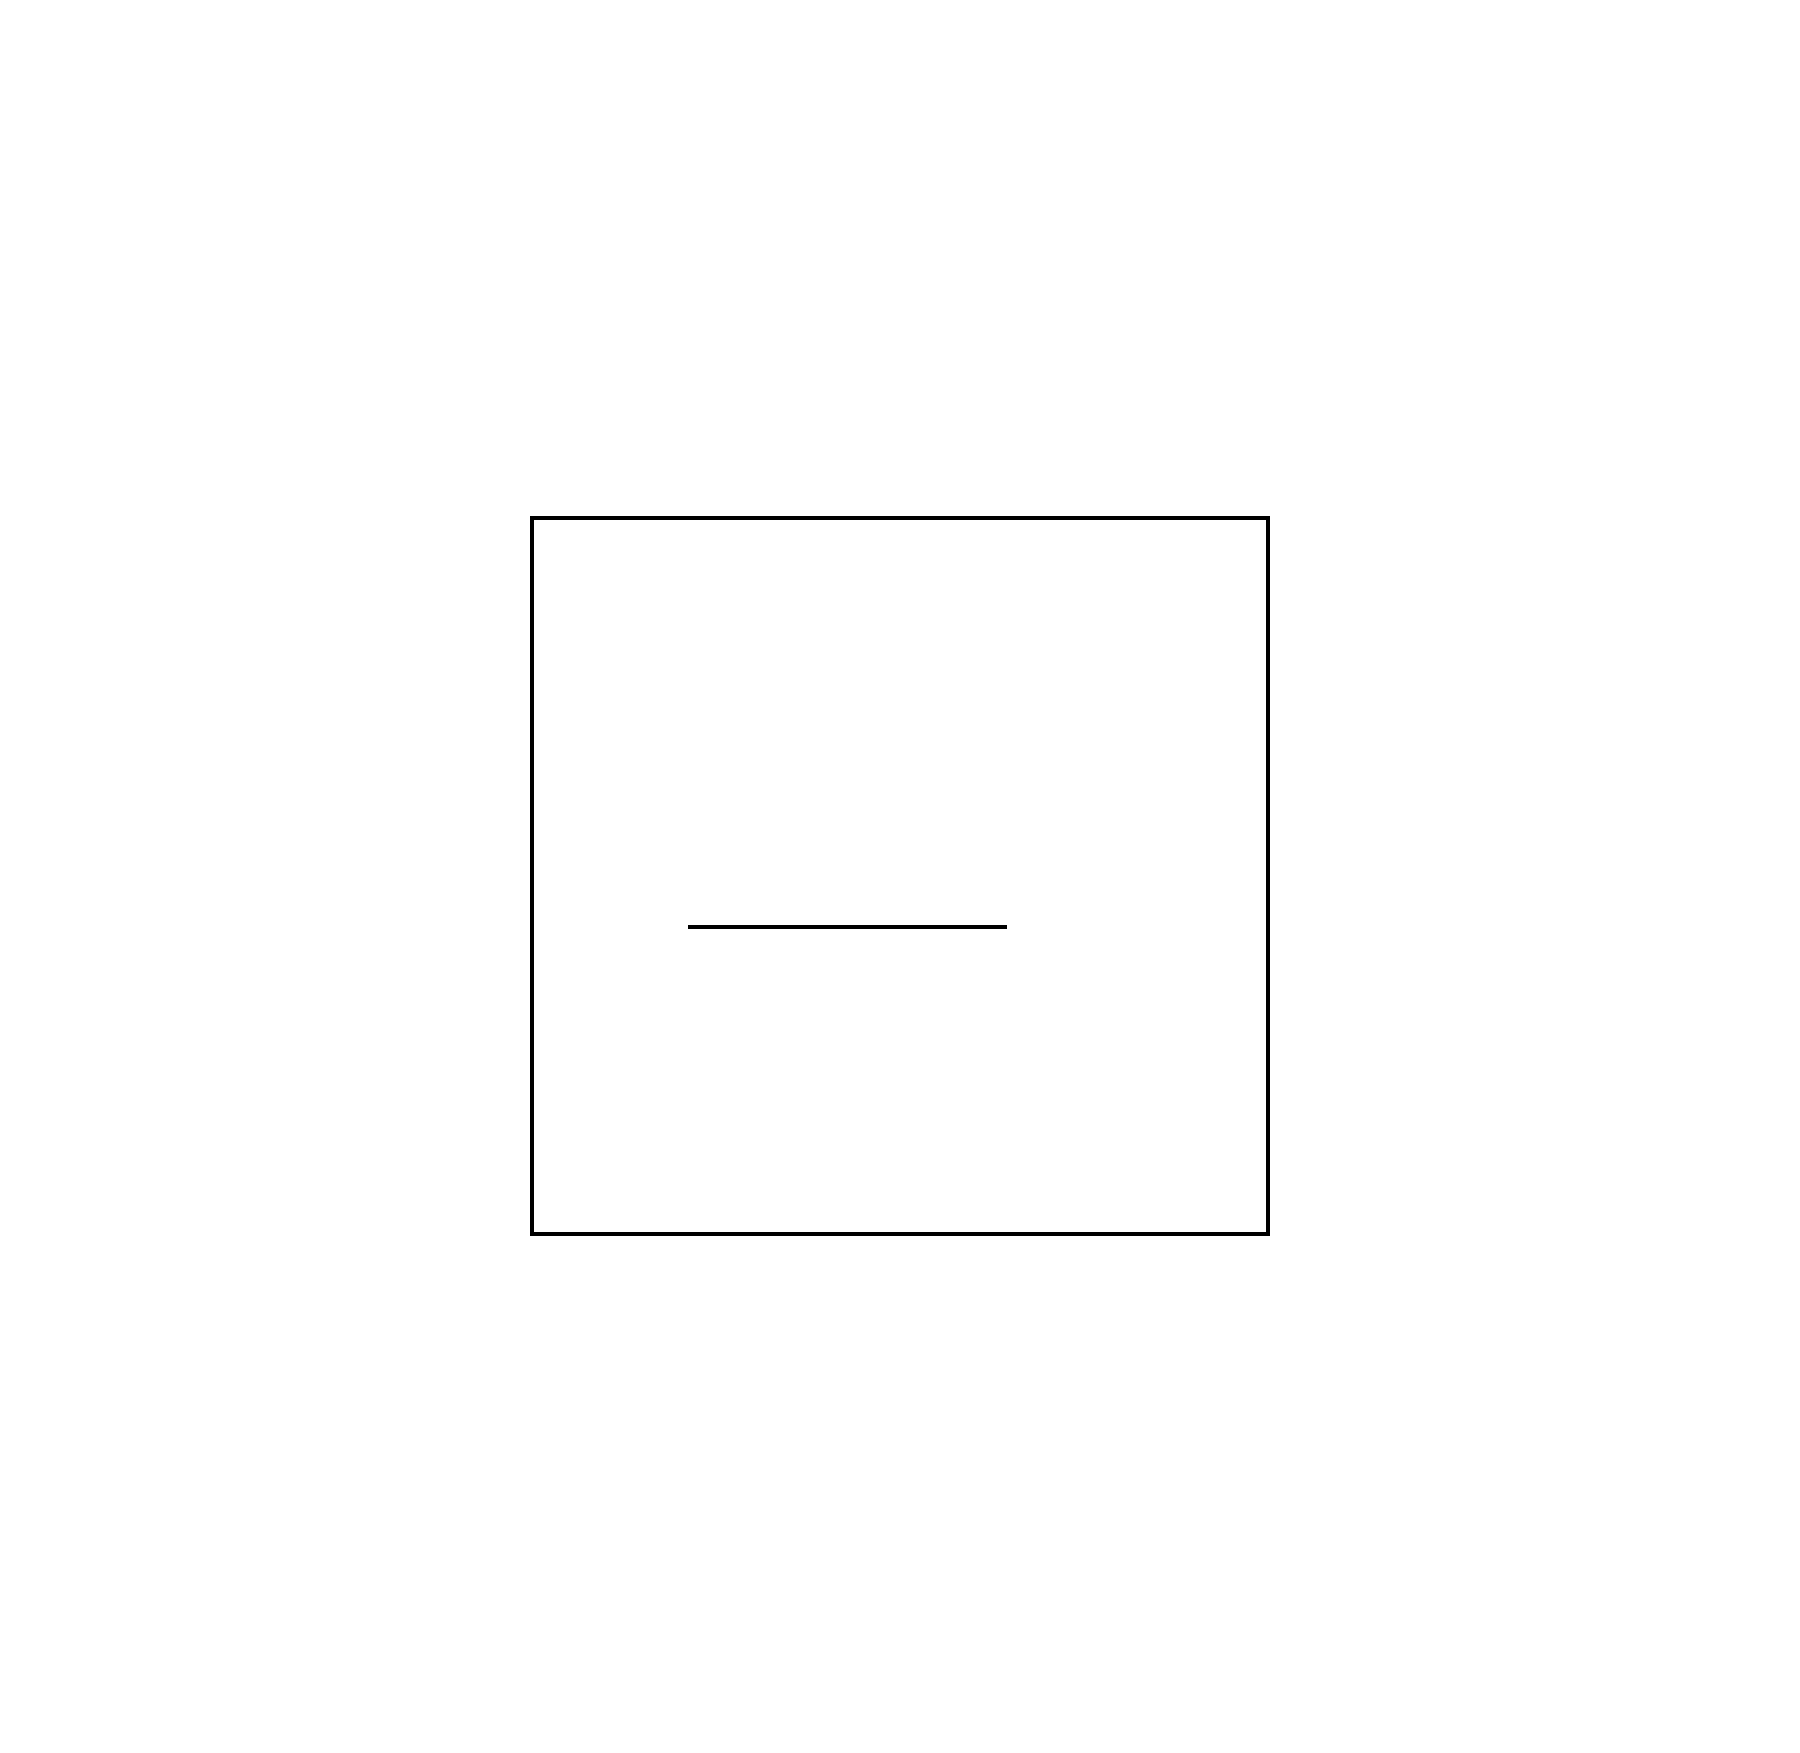

===== Picture 13 =====


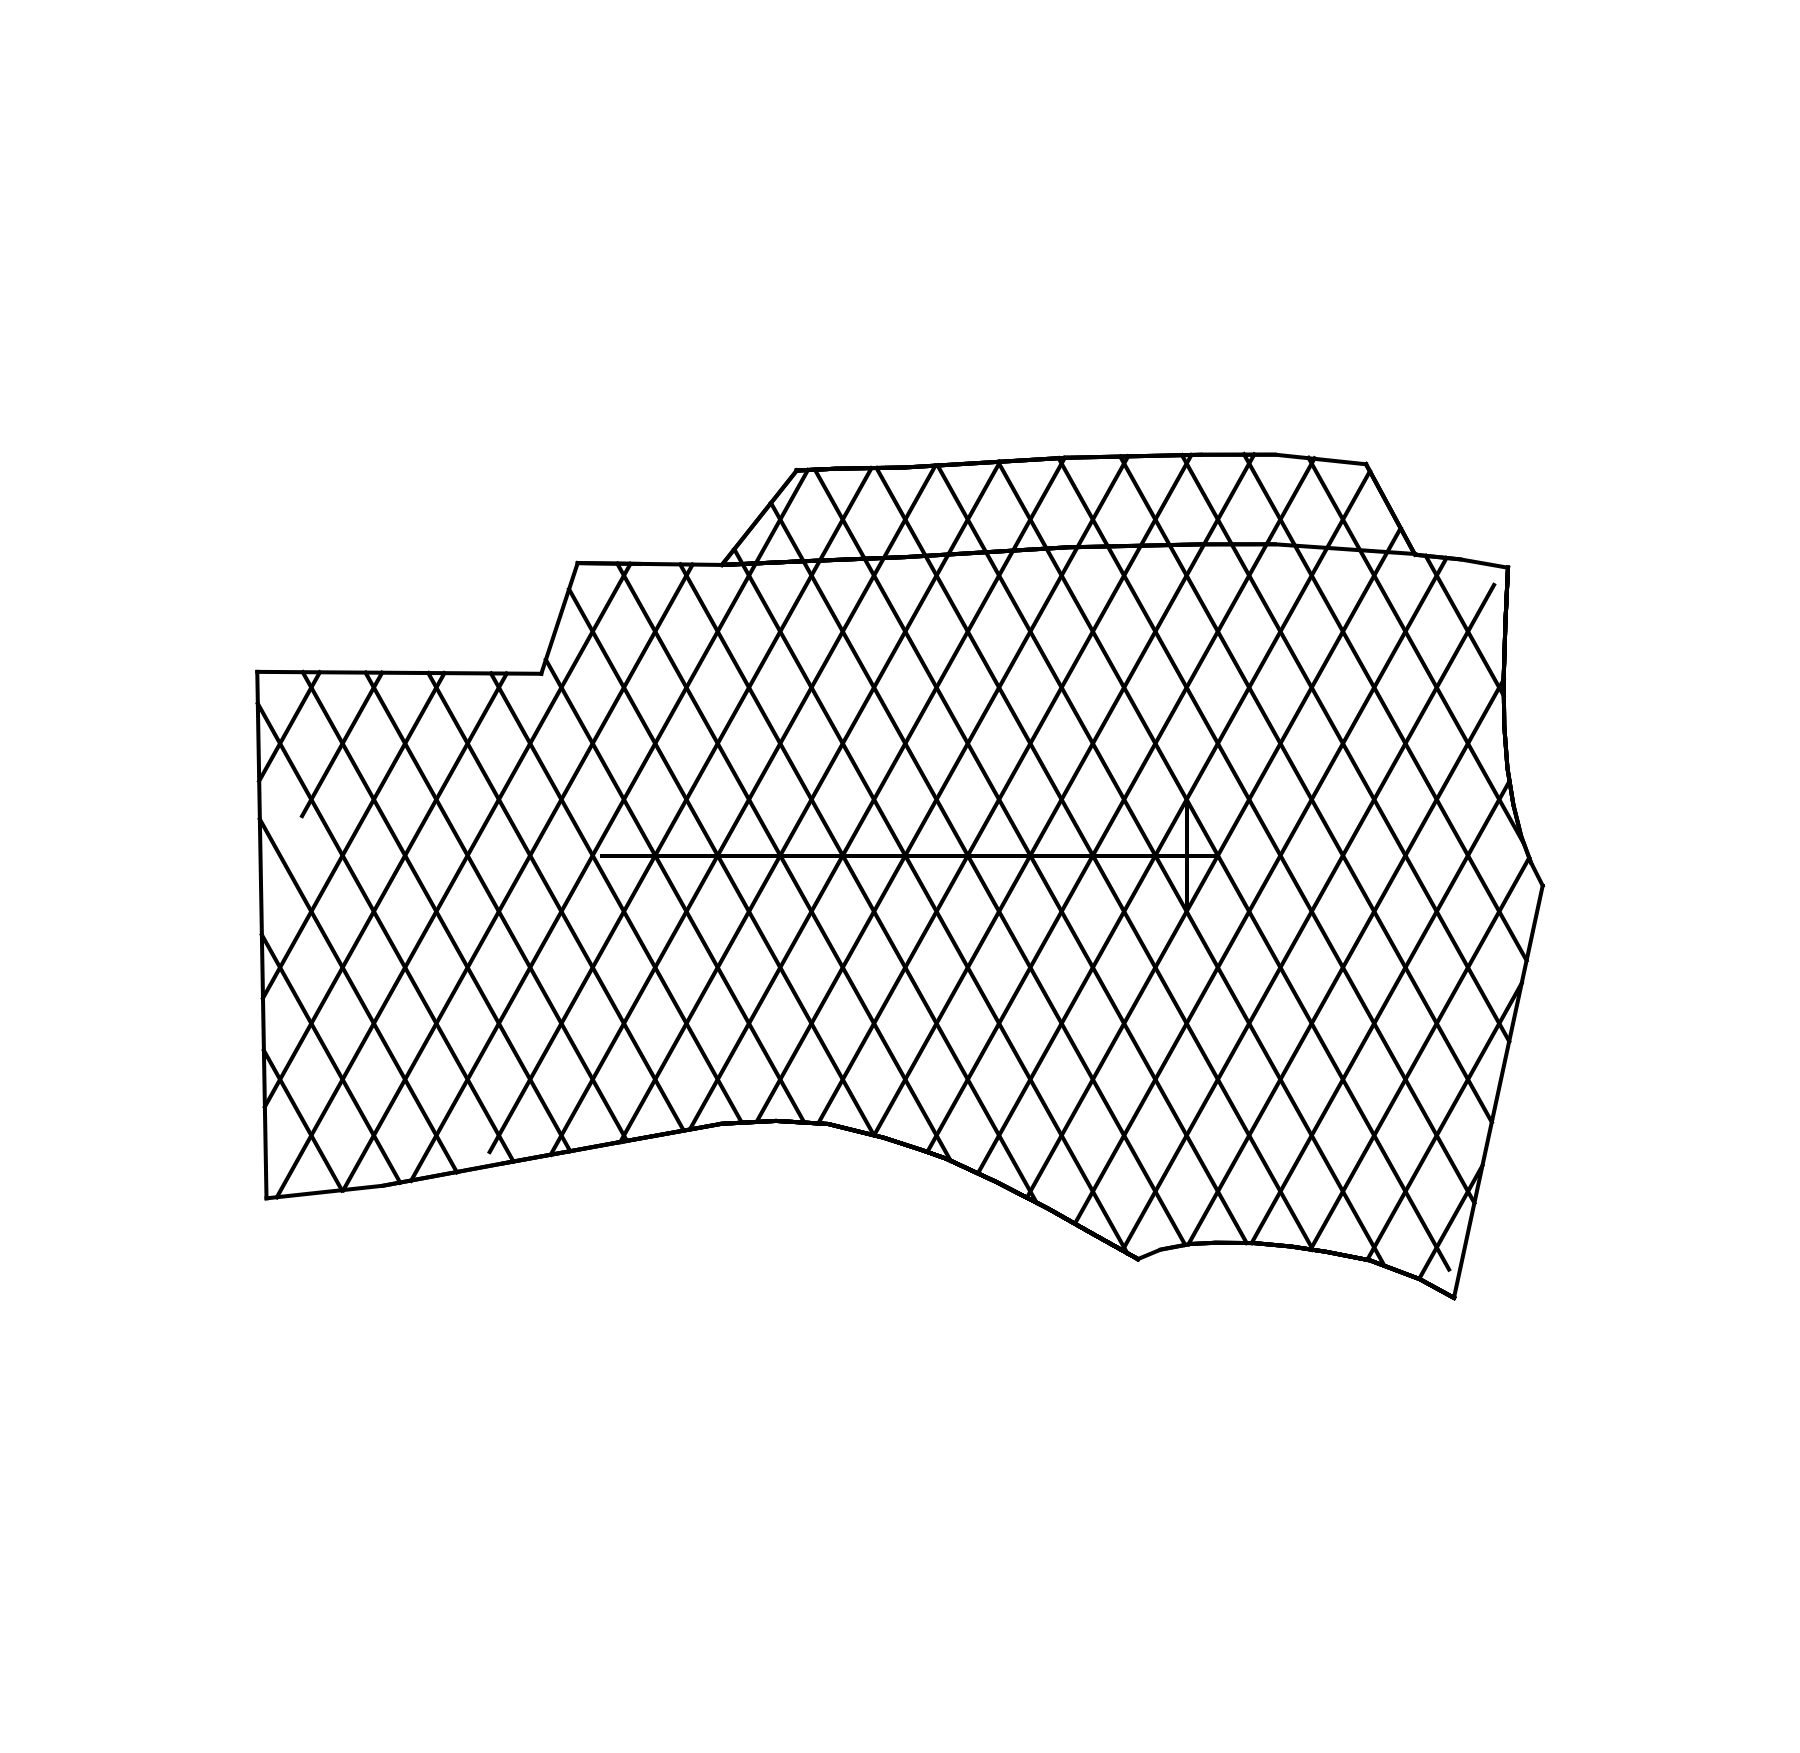

===== Picture 14 =====


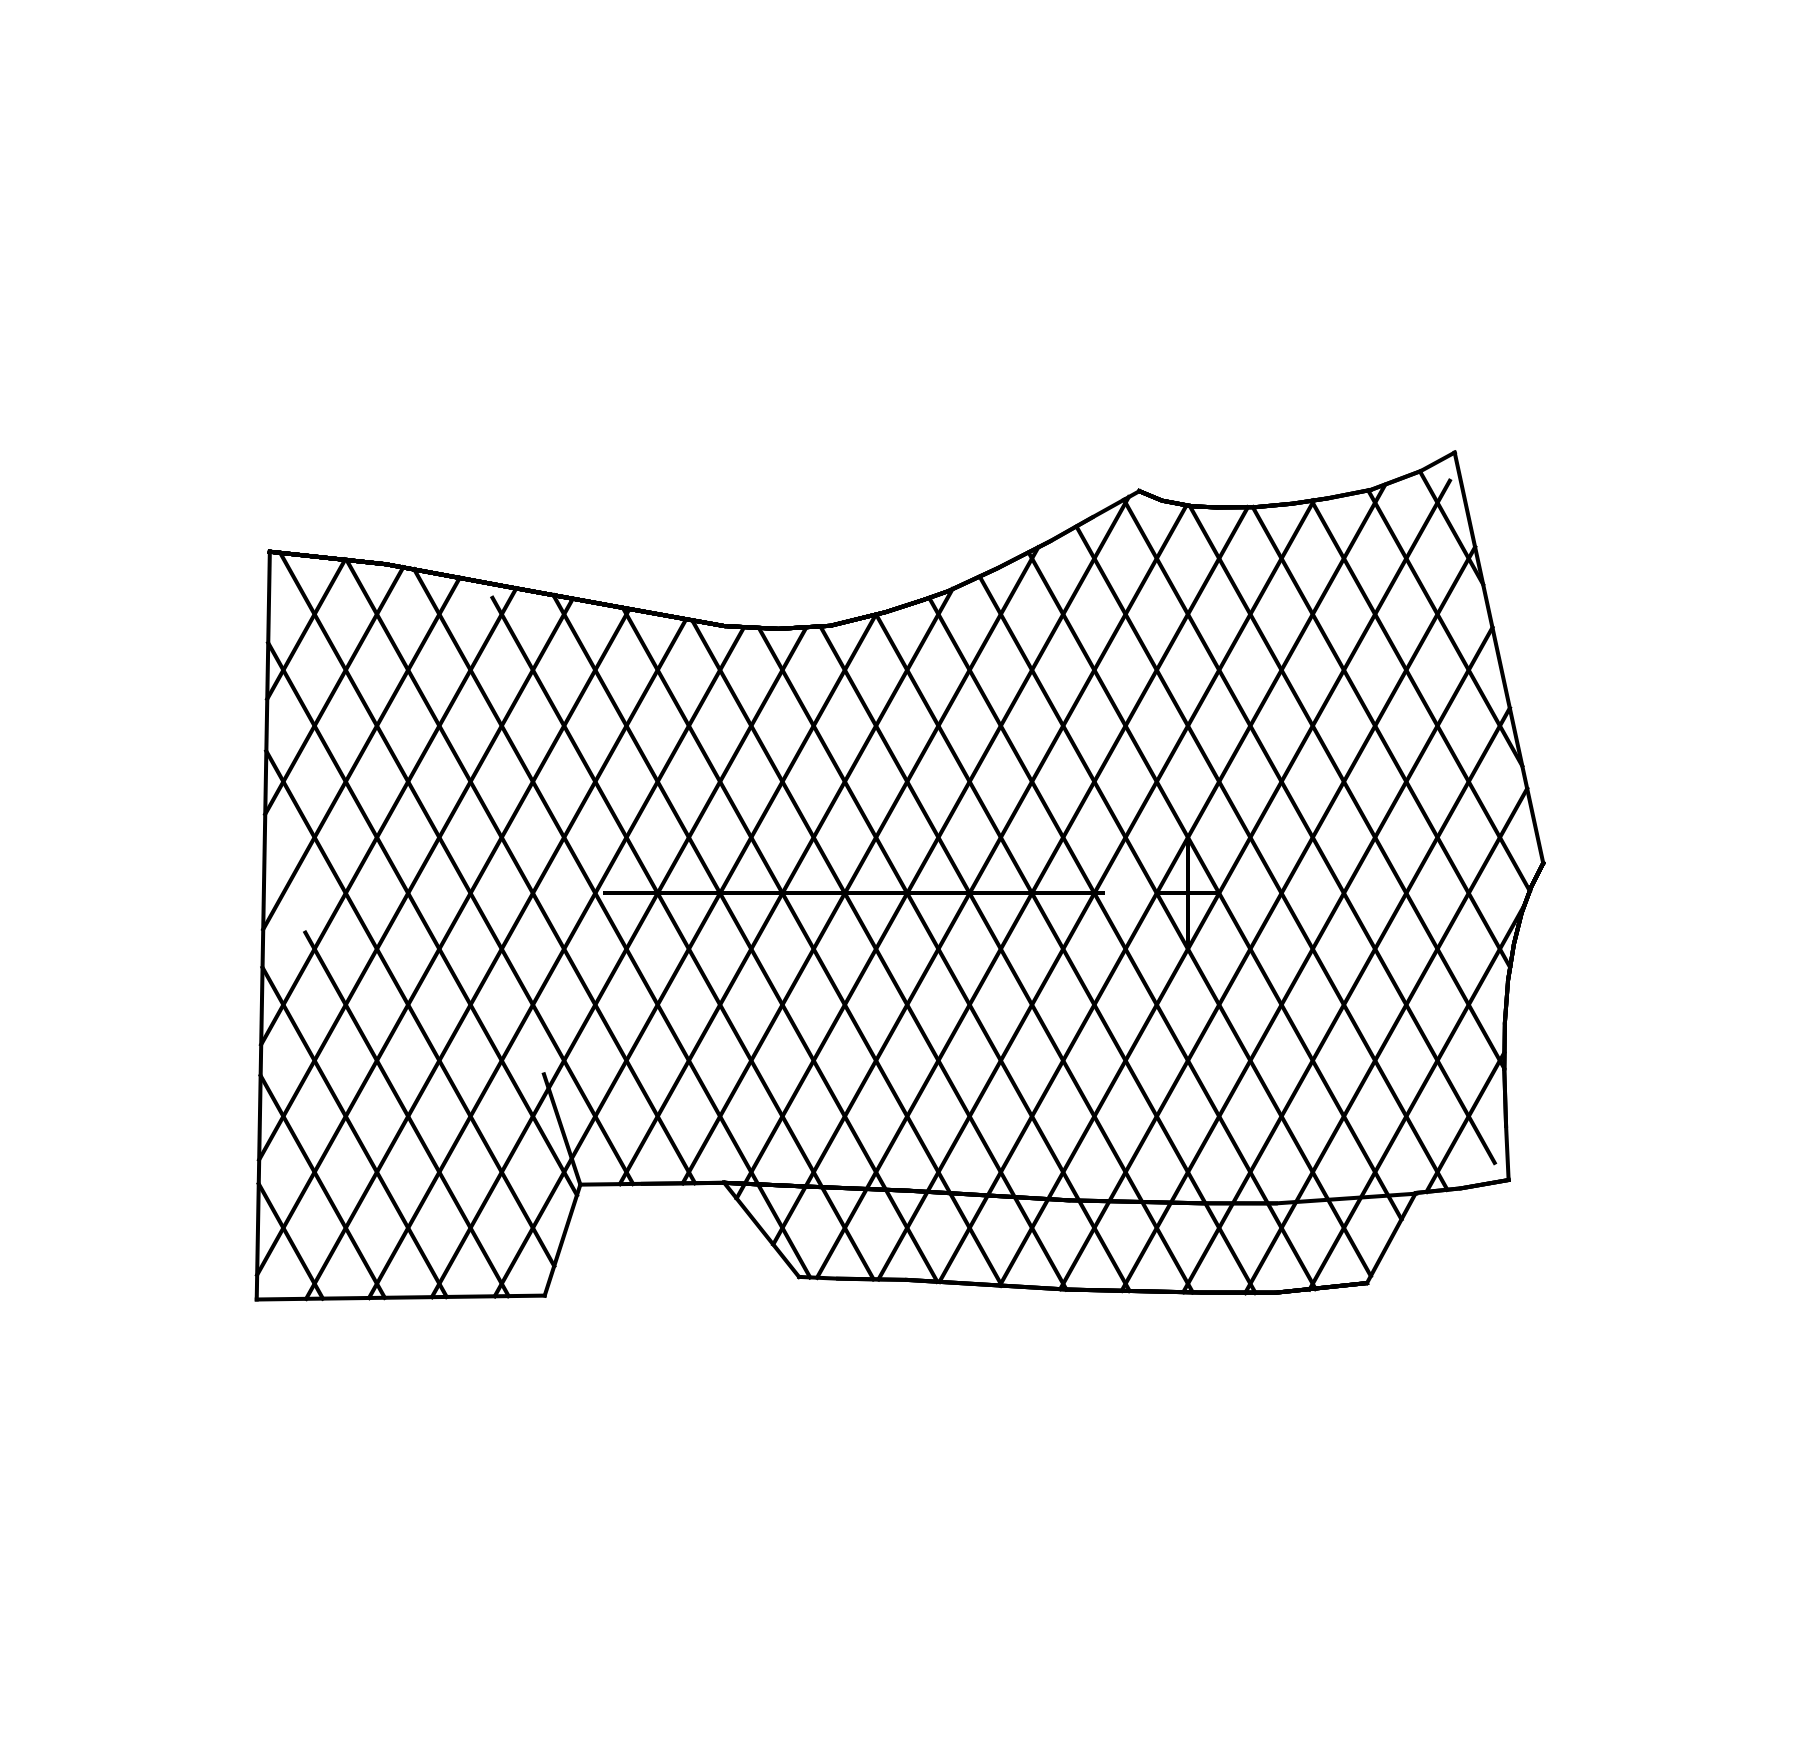

===== Picture 15 =====


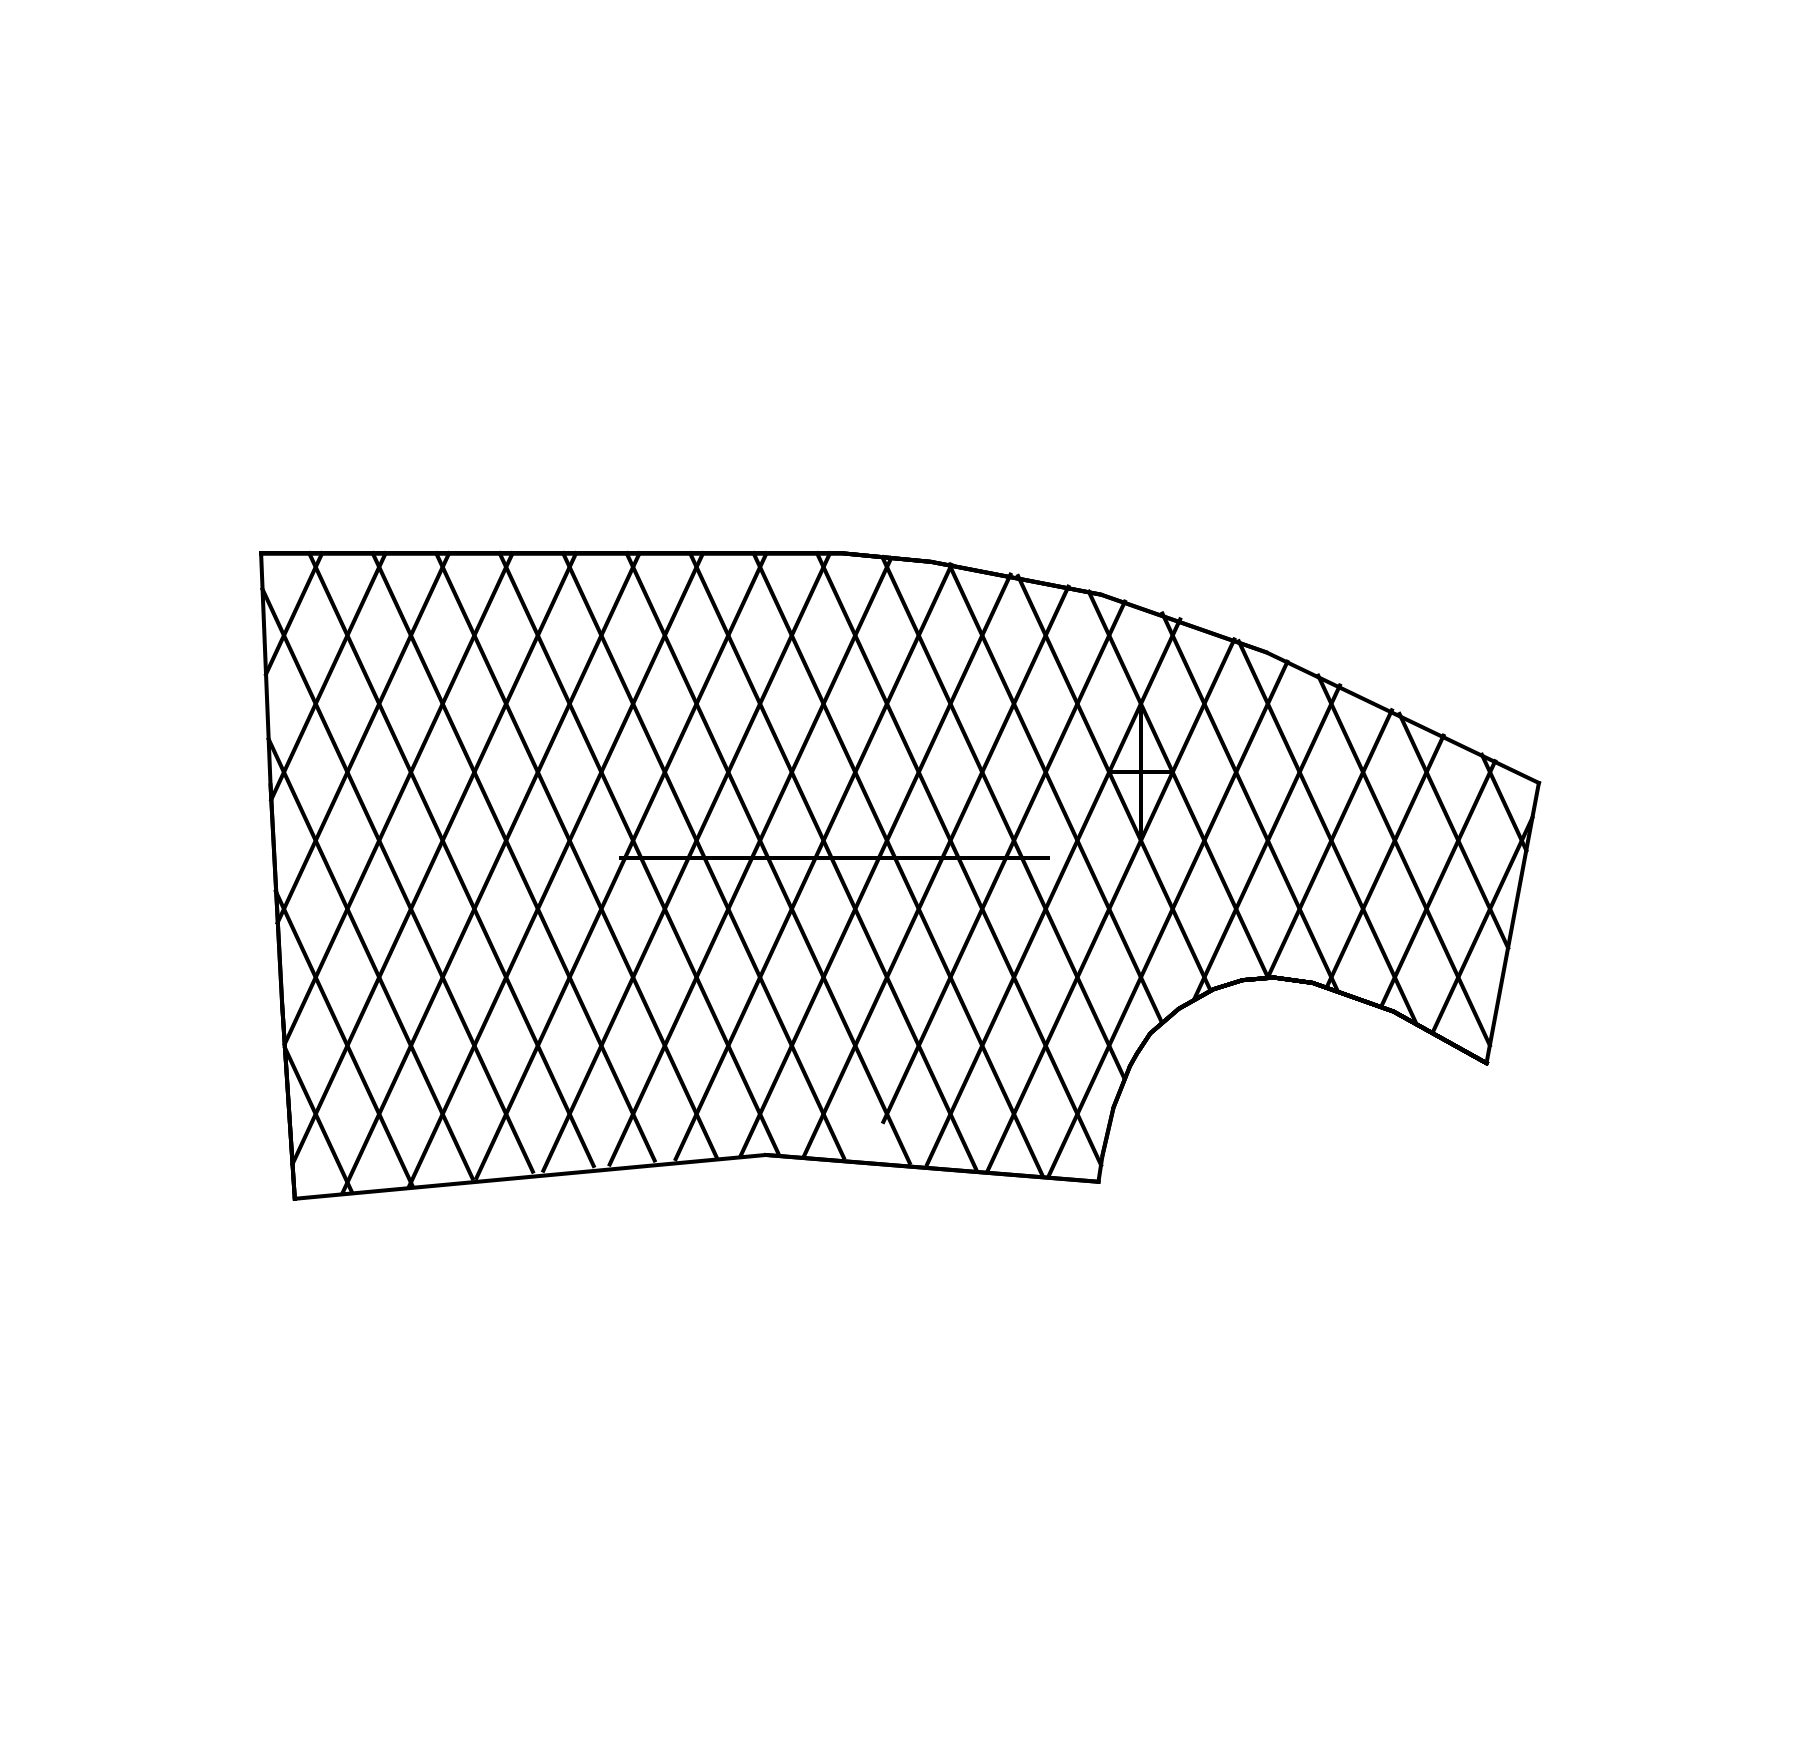

===== Picture 16 =====


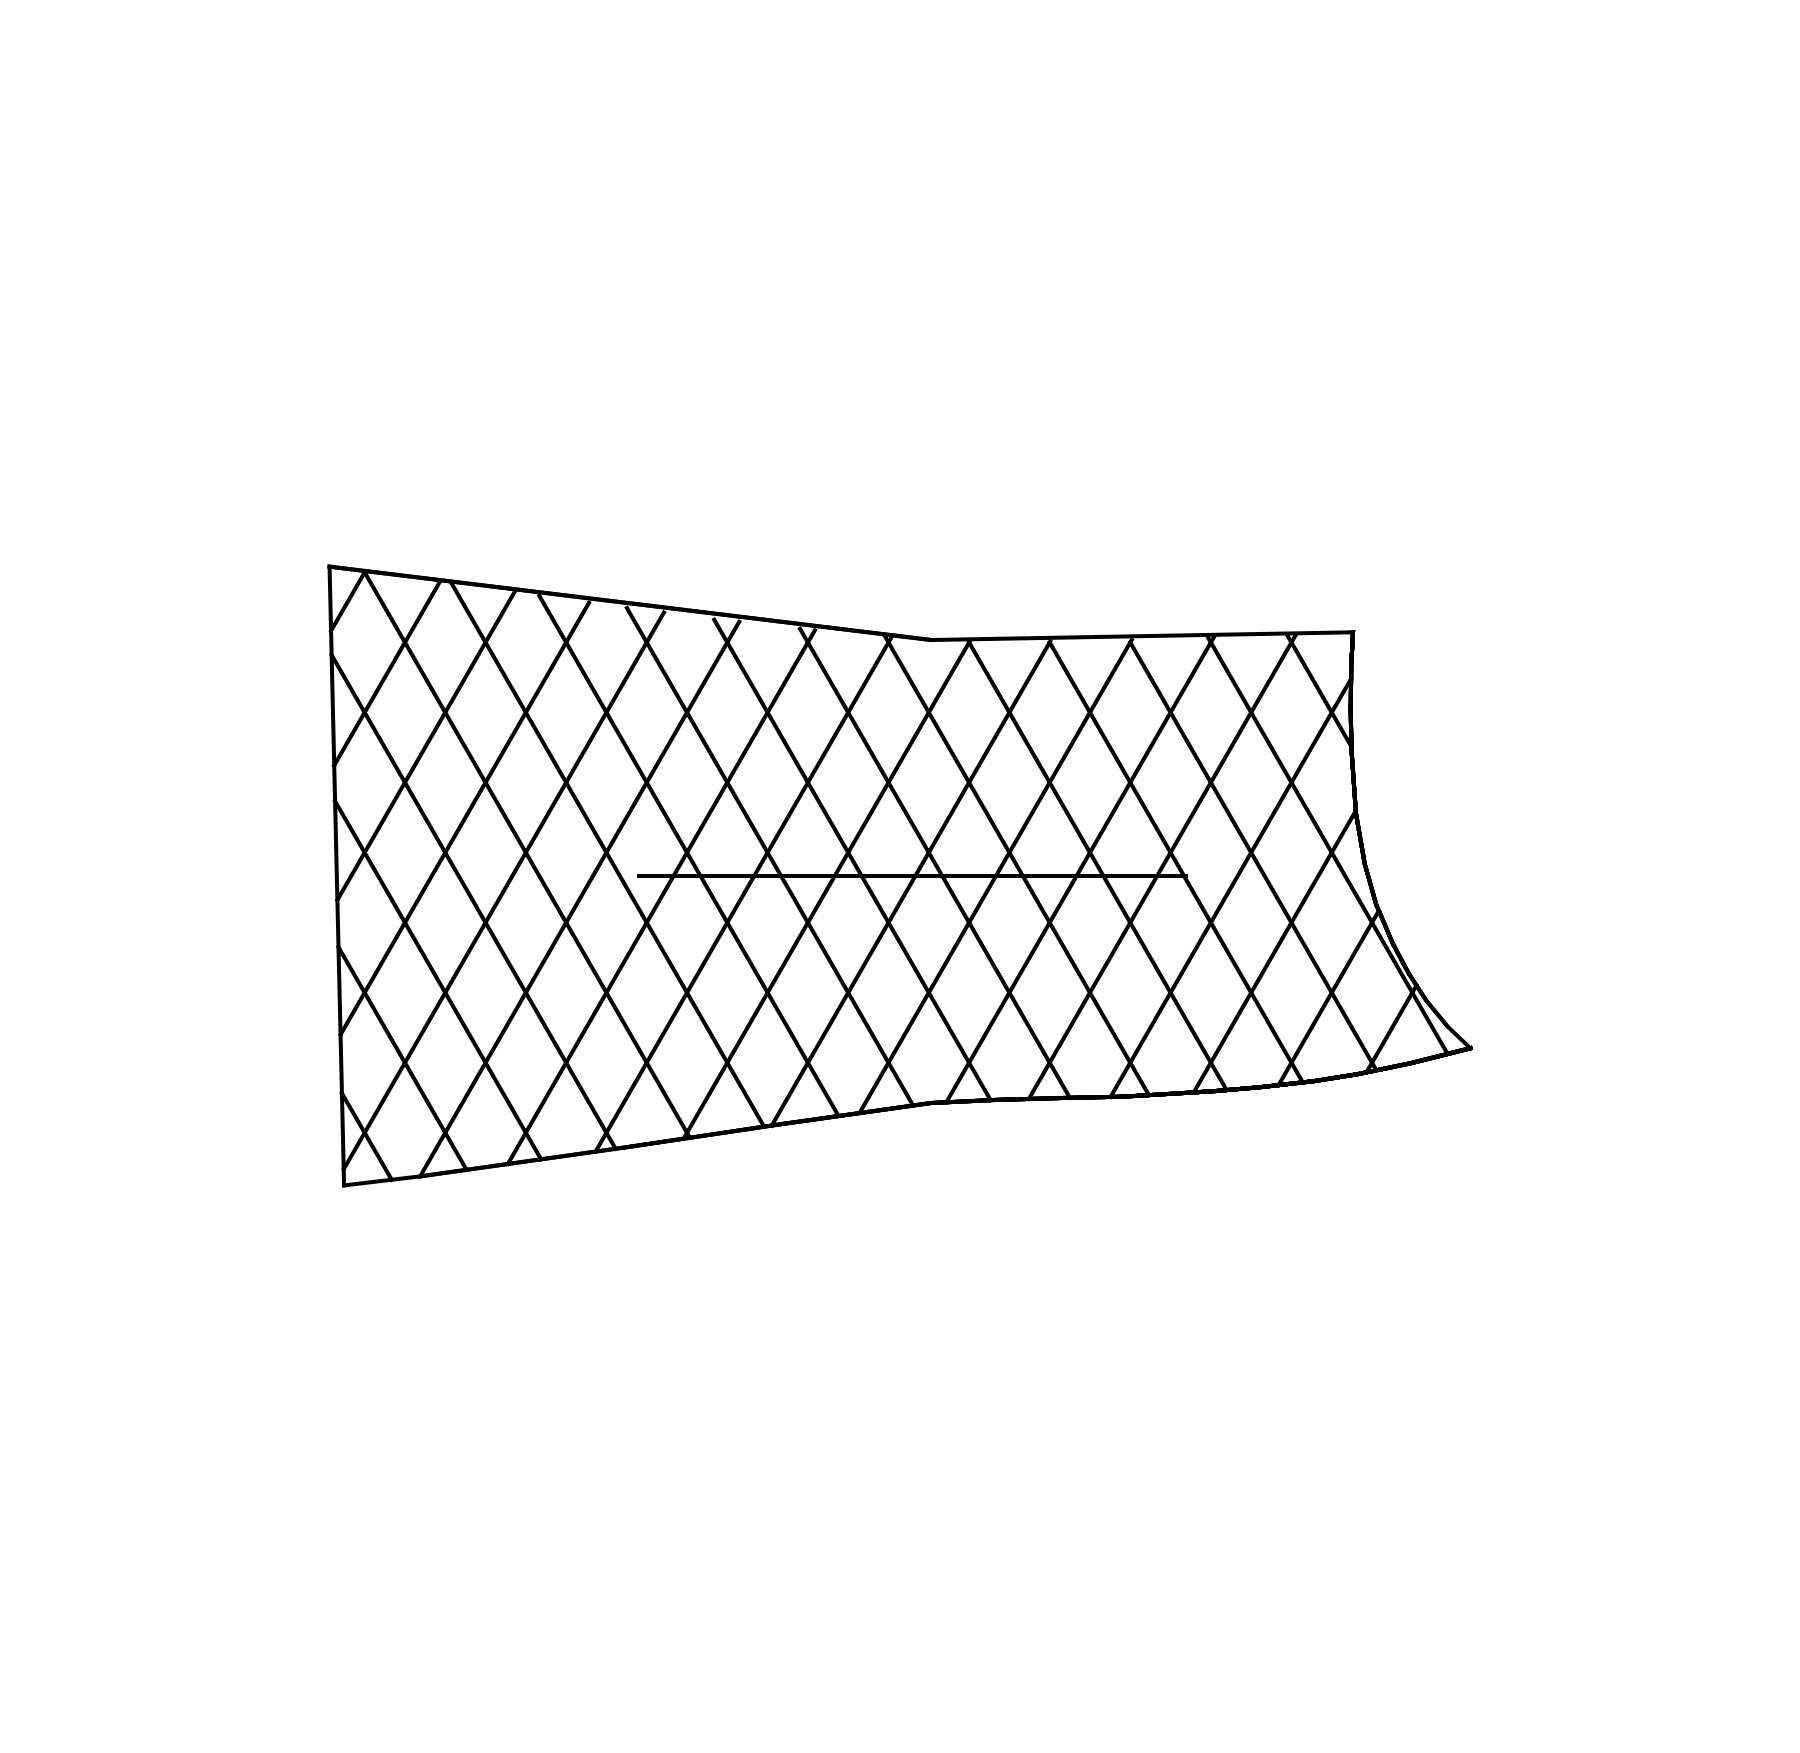

===== Picture 17 =====


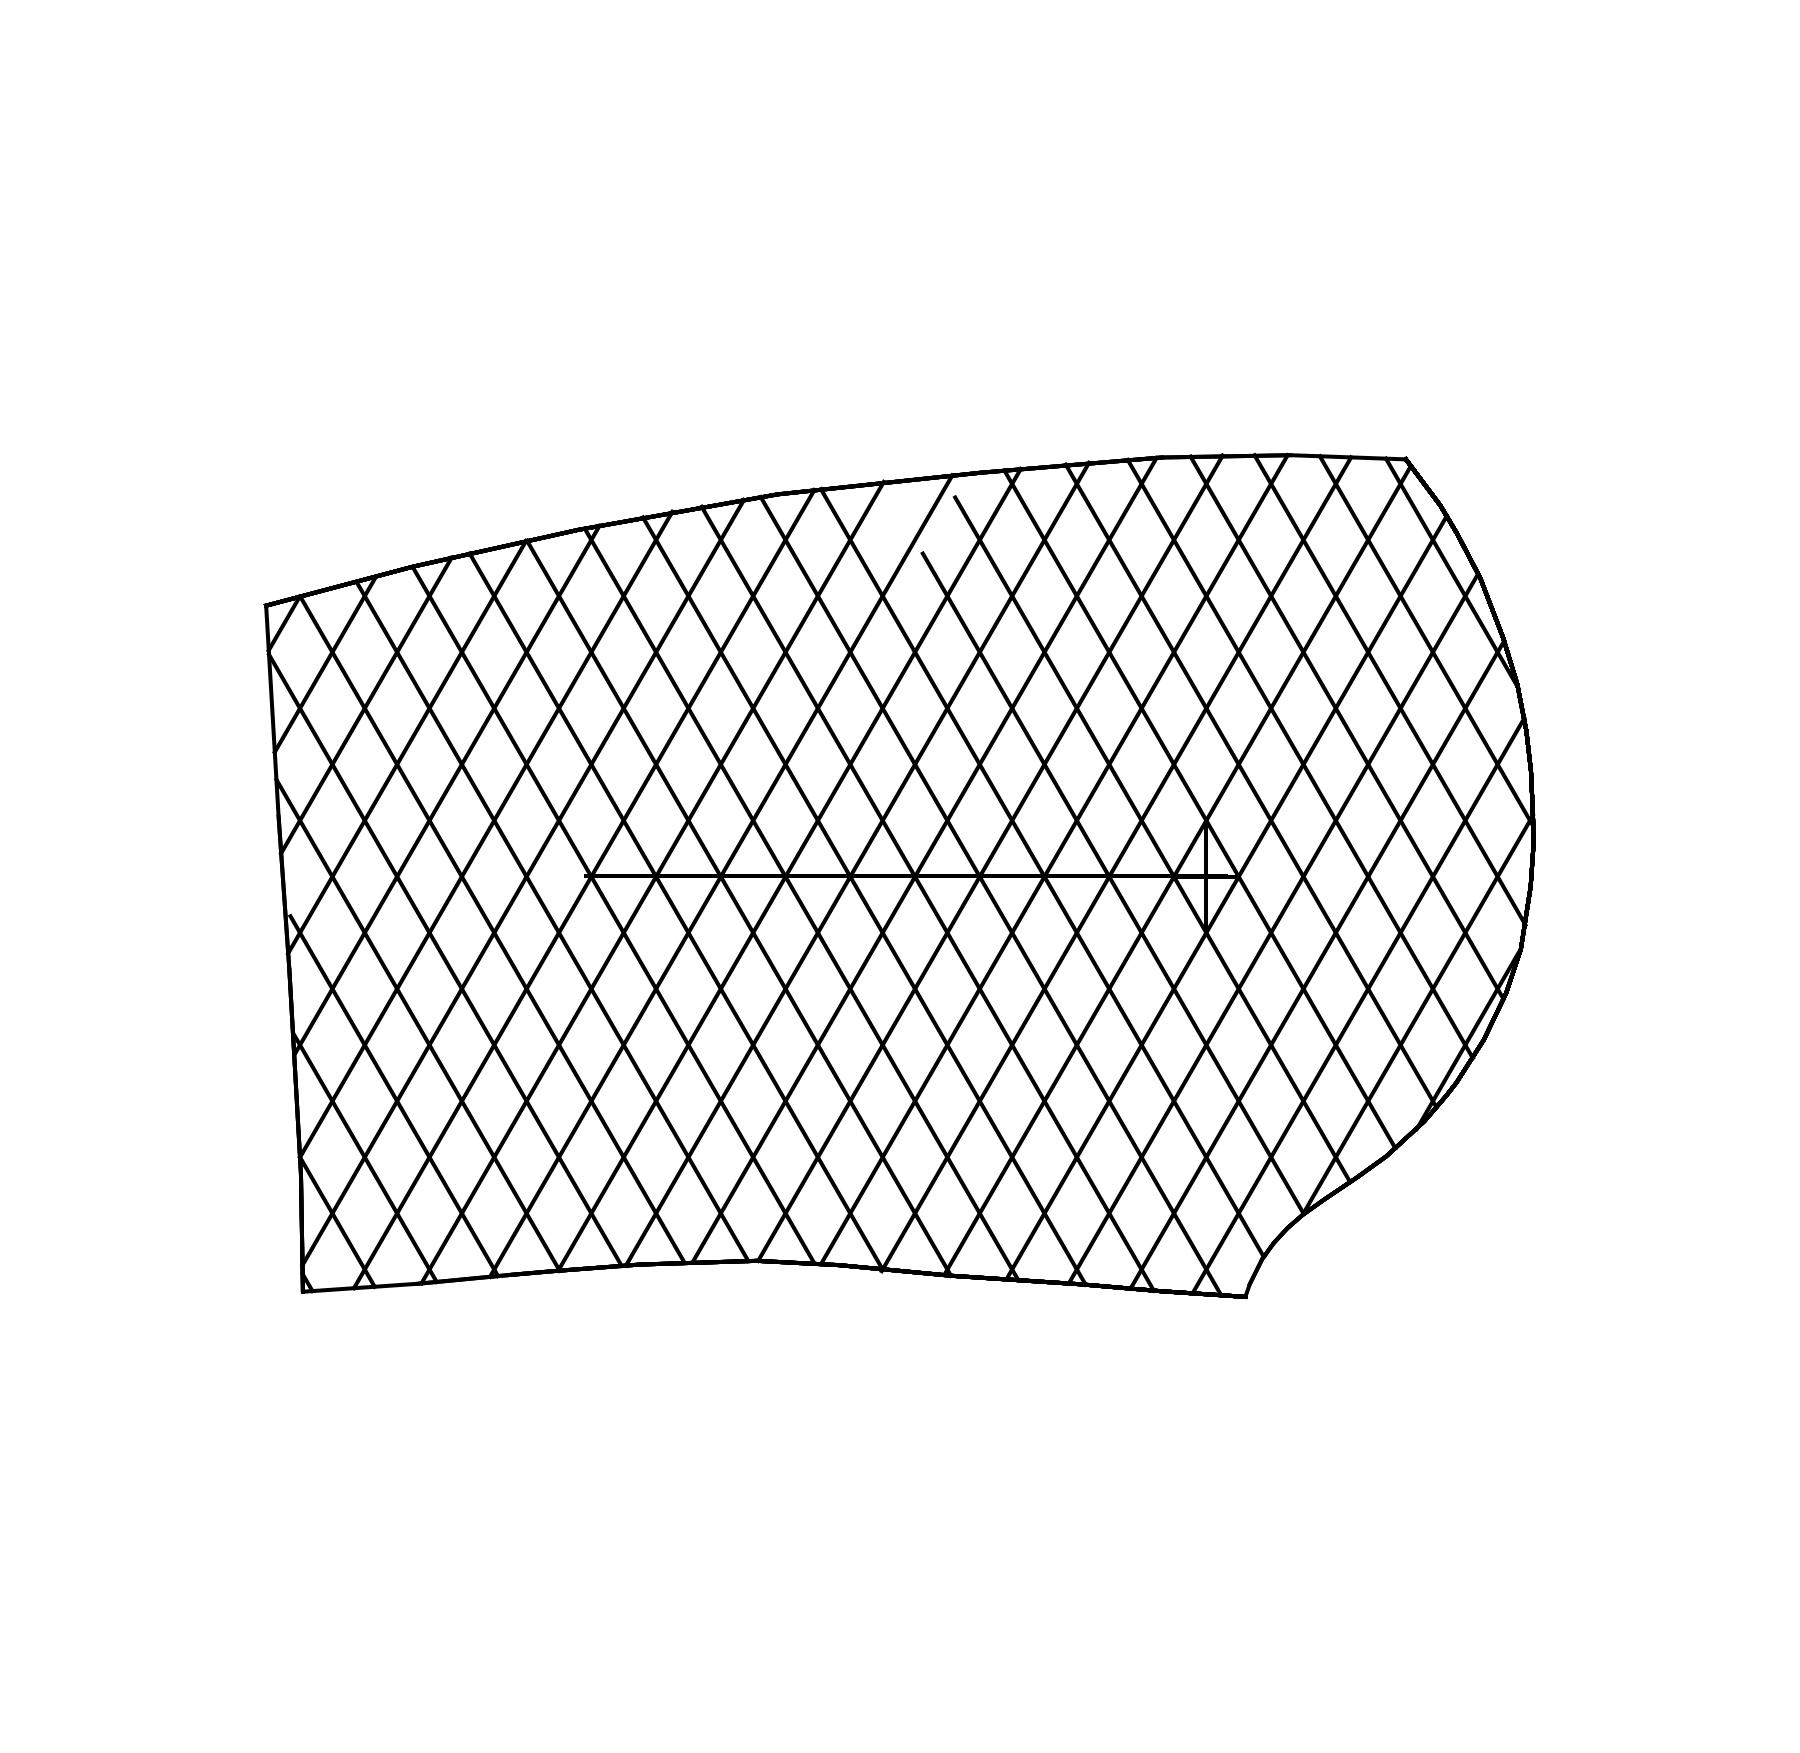

===== Picture 18 =====


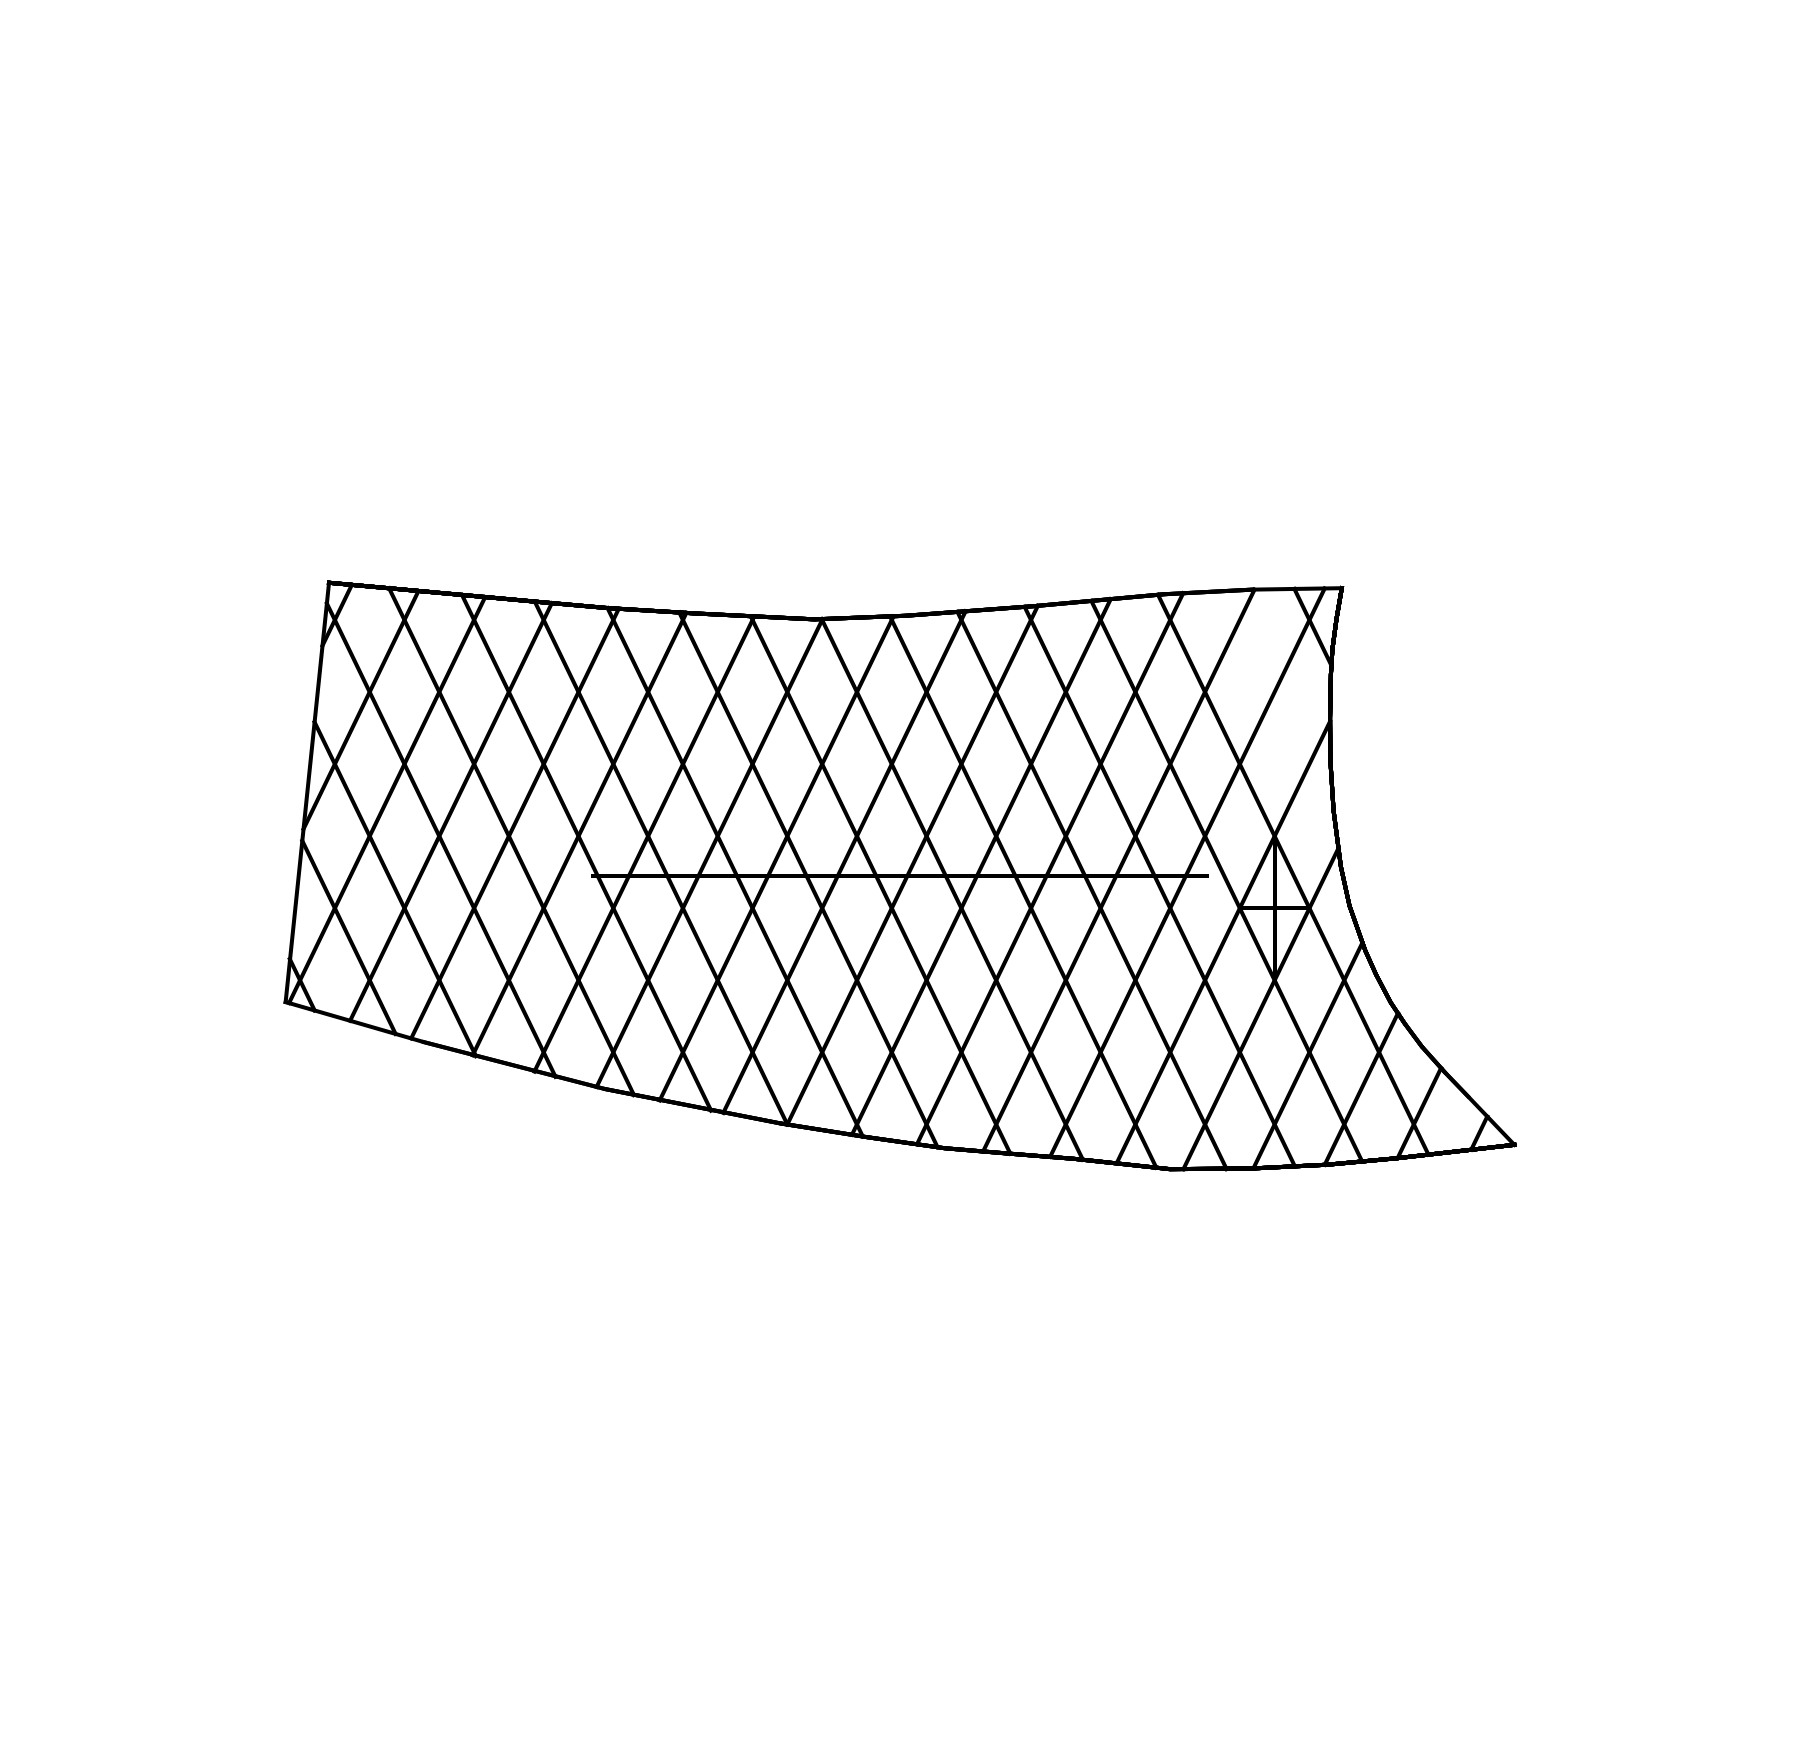

In [24]:
if filename not in os.listdir('../도면별_jpg파일/'):
    os.mkdir(f'../도면별_jpg파일/{filename}')
                              

for file_number in range(1, len(os.listdir(f'../도면별_dxf파일/{filename}/'))+1):
    
    # 데이터 불러오기
    FILENAME = f'../도면별_dxf파일/{filename}/{filename}_{file_number}.dxf'
    new_data = []
    f = open(f"../sample_data/{FILENAME}", 'r', encoding='utf-8')
    data = f.readlines()
    for i in data:
        i = i.replace('\n', '')
        new_data.append(i)
        
        
    # LINE 데이터프레임 생성
    ## Line 좌표추출
    df_line = pd.DataFrame()

    dwg = ezdxf.readfile(FILENAME)
    modelspace = dwg.modelspace()

    for j,insert in enumerate(modelspace.query('INSERT')):
        block = dwg.blocks[insert.dxf.name]
        for e in block:
            if e.dxftype() == 'LINE':
                df_line = df_line.append({'name':e, 'index':j+1, 'start':e.dxf.start, 'end':e.dxf.end}, ignore_index=True)


    ## 대칭그림 생성여부 판단
    lines = [idx for idx in range(len(new_data)) if new_data[idx] == 'LINE']
    symmetry_bool = []
    for idx in range(len(lines)):
        if new_data[lines[idx]+2] == '6':
            symmetry_bool.append(True)
        else:
            symmetry_bool.append(False)

            
    # append element
    df_line = df_line[['index','name','start','end']]
    df_line['start'] = list(map(lambda x: (x[0], x[1]), df_line['start']))
    df_line['end'] = list(map(lambda x: (x[0], x[1]), df_line['end']))
    df_line['symmetry'] = symmetry_bool
    
    
    
    # polyline 데이터프레임 생성
    df_polyline = pd.DataFrame()

    dwg = ezdxf.readfile(FILENAME)
    modelspace = dwg.modelspace()
    polyline_list = []
    for j, insert in enumerate(modelspace.query('INSERT')):
        block = dwg.blocks[insert.dxf.name]
        num = 0
        for e in block:
            if e.dxftype() == 'POLYLINE':
                num += 1
                for i, location in enumerate(e.points()):
                    df_polyline = df_polyline.append({'name':num,'index':j+1,'location':location}, ignore_index=True)

    df_polyline = df_polyline[['index','name','location']]
    df_polyline['location'] = list(map(lambda x: (x[0], x[1]), df_polyline['location']))
    
    
    
    # 시각화
    idx = df_line['index'].unique()[0]
    plt.figure(figsize=(32,32)) # 크기지정: 정사각형 --> 고정

    # line 시각화
    line = df_line[df_line['index'] == idx]
    for name in line.name.unique():
        start_df_point = line.loc[(line['name'] == name), 'start'].values[0]
        end_df_point = line.loc[(line['name'] == name), 'end'].values[0]
        location_x = [start_df_point[0], end_df_point[0]]
        location_y = [start_df_point[1], end_df_point[1]]
        plt.plot(location_x, location_y, color='black', linewidth=4)

    # polyline 시각화
    polyline = df_polyline[df_polyline['index'] == idx]
    for name in polyline.name.unique():
        polyline_location = tuple(polyline.loc[polyline['name'] == name, 'location'])
        location_x = []
        location_y = []
        for loc in polyline_location:
            location_x.append(loc[0])
            location_y.append(loc[1])
            plt.plot(location_x, location_y, color='black', linewidth=4)

    # 대칭을 그려야한다면 대칭그림을 시각화
    if True in list(line['symmetry']):
        symmetry_df = line[line['symmetry'] == True].reset_index(drop=True).loc[0]
        axis_point1 = symmetry_df['start']
        axis_point2 = symmetry_df['end']

        ## line
        for name in line.name.unique():
            start_df_point = line.loc[(line['name'] == name), 'start'].values[0]
            end_df_point = line.loc[(line['name'] == name), 'end'].values[0]
            start_df_point = get_symmetry_point(start_df_point, axis_point1, axis_point2)
            end_df_point = get_symmetry_point(end_df_point, axis_point1, axis_point2)
            location_x = [start_df_point[0], end_df_point[0]]
            location_y = [start_df_point[1], end_df_point[1]]
            plt.plot(location_x, location_y, color='black', linewidth=4)

        ## polyline
        for name in polyline.name.unique():
            polyline_location = tuple(polyline.loc[polyline['name'] == name, 'location'])
            location_x = []
            location_y = []
            for loc in polyline_location:
                loc = get_symmetry_point(loc, axis_point1, axis_point2)
                location_x.append(loc[0])
                location_y.append(loc[1])
                plt.plot(location_x, location_y, color='black', linewidth=4)

    # 축법위 지정
    print(f'===== Picture {int(file_number)} =====')
    poly_max_x = max(list(map(lambda x: x[0], polyline['location'])))
    poly_min_x = min(list(map(lambda x: x[0], polyline['location'])))
    poly_max_y = max(list(map(lambda x: x[1], polyline['location'])))
    poly_min_y = min(list(map(lambda x: x[1], polyline['location'])))

    line_start_max_x = max(list(map(lambda x: x[0], line['start'])))
    line_start_min_x = min(list(map(lambda x: x[0], line['start'])))
    line_start_max_y = max(list(map(lambda x: x[1], line['start'])))
    line_start_min_y = min(list(map(lambda x: x[1], line['start'])))

    line_end_max_x = max(list(map(lambda x: x[0], line['end'])))
    line_end_min_x = min(list(map(lambda x: x[0], line['end'])))
    line_end_max_y = max(list(map(lambda x: x[1], line['end'])))
    line_end_min_y = min(list(map(lambda x: x[1], line['end'])))

    x_lim_max = max(poly_max_x, line_start_max_x, line_end_max_x)
    x_lim_min = min(poly_min_x, line_start_min_x, line_end_min_x)
    y_lim_max = max(poly_max_y, line_start_max_y, line_end_max_y)
    y_lim_min = min(poly_min_y, line_start_min_y, line_end_min_y)

    ## 대칭을 그려야한다면 대칭범위도 고려 필요
    if True in list(line['symmetry']):
        polyline_sy = list(map(lambda x: get_symmetry_point(x, axis_point1, axis_point2), polyline['location']))
        poly_max_x = max(list(map(lambda x: x[0], polyline_sy)))
        poly_min_x = min(list(map(lambda x: x[0], polyline_sy)))
        poly_max_y = max(list(map(lambda x: x[1], polyline_sy)))
        poly_min_y = min(list(map(lambda x: x[1], polyline_sy)))

        line_start_sy = list(map(lambda x: get_symmetry_point(x, axis_point1, axis_point2), line['start']))
        line_start_max_x = max(list(map(lambda x: x[0], line_start_sy)))
        line_start_min_x = min(list(map(lambda x: x[0], line_start_sy)))
        line_start_max_y = max(list(map(lambda x: x[1], line_start_sy)))
        line_start_min_y = min(list(map(lambda x: x[1], line_start_sy)))

        line_end_sy = list(map(lambda x: get_symmetry_point(x, axis_point1, axis_point2), line['end']))
        line_end_max_x = max(list(map(lambda x: x[0], line_end_sy)))
        line_end_min_x = min(list(map(lambda x: x[0], line_end_sy)))
        line_end_max_y = max(list(map(lambda x: x[1], line_end_sy)))
        line_end_min_y = min(list(map(lambda x: x[1], line_end_sy)))

        x_lim_max = max(x_lim_max, poly_max_x, line_start_max_x, line_end_max_x)
        x_lim_min = min(x_lim_min, poly_min_x, line_start_min_x, line_end_min_x)
        y_lim_max = max(y_lim_max, poly_max_y, line_start_max_y, line_end_max_y)
        y_lim_min = min(y_lim_min, poly_min_y, line_start_min_y, line_end_min_y)

    plt.xlim([float(x_lim_min-5), float(x_lim_max+5)])
    plt.ylim([float(y_lim_min-5), float(y_lim_max+5)])
    plt.axis('off')
    plt.savefig(f'../도면별_jpg파일/{filename}/{filename}_{file_number}.jpg')
    plt.show()